# Preamble

In [1]:
import attr
import funcy as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict
from IPython.display import Image, display, SVG
import networkx as nx
import pydot
import pandas as pd

from collections import Counter

import dfa
from dfa.utils import find_subset_counterexample, find_equiv_counterexample
from dfa_identify import find_dfa, find_dfas

from diss.planners.product_mc import ProductMC
from diss.concept_classes.dfa_concept import DFAConcept
from diss.concept_classes.dfa_decomposition_concept import DFAProductConcept
from diss.domains.gridworld_naive import GridWorldNaive as World
from diss.domains.gridworld_naive import GridWorldState as State
from diss import search, LabeledExamples, GradientGuidedSampler, ConceptIdException
from pprint import pprint
from itertools import combinations
from tqdm import tqdm_notebook
from tqdm.notebook import trange
from IPython.display import clear_output
from IPython.display import HTML as html_print
from functools import reduce, partial

sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')
np.set_printoptions(precision=3)

In [2]:
from diss.experiment import PartialDFAIdentifier, ignore_white, PARTIAL_DFA, BASE_EXAMPLES
from diss.experiment.concept_class import PartialProductDFAIdentifier
from diss.experiment.vis import view_dfas

In [3]:
from diss import diss

In [4]:
from diss import DemoPrefixTree as PrefixTree

In [5]:
def analyze(search, n_iters):
    concept2energy = {}    # Explored concepts + associated energy
    partial_masses = []
    median_energies = []
    min_energies = []
    total_energies = []
    # Run Search and collect concepts, energy, and POI.
    for i, (data, concept, metadata) in zip(trange(n_iters, desc='DISS'), search):
        print(f'==========={i}================')
        print('size', concept.size)
        
        score = metadata['energy']
        print('energy', score)
        if 'grad' in metadata:
            print('surprisal', metadata.get('surprisal'))
            grad = metadata['grad']
            sns.set(rc={"figure.figsize":(10, 2)})
            sns.barplot(x=np.arange(len(grad)), y=np.array(grad) / np.abs(grad).max())
            plt.xticks(rotation=45)
            plt.show()
            weights = metadata['weights']
            sns.set(rc={"figure.figsize":(10, 2)})
            sns.barplot(x=np.arange(len(weights)), y=np.array(weights))
            plt.xticks(rotation=45)
            plt.show()
            print('pivot', metadata['pivot'])

            print("conjecture:")
            print(f"{metadata['conjecture']}")
            print(f'data')
            data = metadata['data']
            data @= identifer.base_examples  # Force labels of prior examples.
            buff = ''
            for lbl, split in [(True, data.positive), (False, data.negative)]:
                buff += f'------------- {lbl} --------------<br>'
                for word in sorted(split, key=len):
                    obs = '\n'.join(map(tile, word))
                    buff += f'{obs}<br>'
            display(html_print(buff))
        
        
        concept2energy[concept] = metadata['energy']
        view_dfas(concept)
        energies = list(concept2energy.values())
        partial_masses.append(sum(np.exp(-x) for x in energies))  # Record unormalized mass
        
        median_energies.append(np.median(energies))
        min_energies.append(np.min(energies))
        total_energies.append(sum(energies))

    sorted_concepts = sorted(list(concept2energy), key=concept2energy.get)
    
    p = 0
    for c in sorted(concept2energy, key=concept2energy.get):
        p += np.exp(-concept2energy[c])
        print('energy', concept2energy[c])
        view_dfas(c)
        if p > 0.99:
            break


    
    df = pd.DataFrame(data={
        'probability mass explored': partial_masses,
        'median energies': median_energies,
        'min energies': min_energies,
        'cumulative energy': total_energies,
        'iteration': list(range(1, len(total_energies) + 1)),
    })
    return df, sorted_concepts

In [6]:
from diss.experiment.planner import GridWorldPlanner
planner = GridWorldPlanner.from_string(
    buff="""y....g..
    ........
    .b.b...r
    .b.b...r
    .b.b....
    .b.b....
    rrrrrr.r
    g.y.....""",
    start=(3, 5),
    slip_prob=1/32,
    horizon=15,
    policy_cache='diss_experiment.shelve',
)
SENSOR = planner.gw.sensor
DYN = planner.gw.dyn

## Visualizing Overlay

This can all seem pretty abstract, so let's visualize the way the sensor sees the board.

In [7]:
from IPython.display import HTML as html_print

COLOR_ALIAS = {
    'white': 'white',
    'yellow': '#ffff00', 
    'red': '#ff8b8b',
    'blue': '#afafff', 
    'green' : '#8ff45d'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def print_map():
    """Scan the board row by row and print colored tiles."""
    order = range(1, 9)
    buffer = ''
    for y in order:
        chars = (tile(planner.gw.ap_at_state(x, y)) for x in order)
        buffer += '&nbsp;'.join(chars) + '<br>'
    display(html_print(buffer))
    
DYN_SENSE = DYN >> SENSOR


def print_trc(trc, idx=0):
    obs = planner.lift_path(trc, flattened=False, compress=False)
    actions = [x['a'] for x in trc[1:]]
    obs = map(tile, obs)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )
        
print_map()

TRC4 = [
    (3, 5),
    {'a': '↑', 'c': 0},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1, 'EOE_ego': 1},
]

TRC5 = [
    (3, 5),
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    #{'a': '↑', 'c': 1},
    #{'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1, 'EOE_ego': 1},
]


print(len(TRC4))

print_trc(TRC4, 4)
print_trc(TRC5, 5)

15


In [8]:
import random

In [9]:
env_yellow = dfa.DFA(
    start=False,
    inputs={'blue', 'green', 'red', 'yellow'},
    outputs={True, False},
    label=lambda s: s,
    transition=lambda s, c: s | (c == 'yellow'),
)

In [10]:
universal = dfa.DFA(
    start=True,
    inputs={'blue', 'green', 'red', 'yellow'},
    outputs={True, False},
    label=lambda s: s,
    transition=lambda s, c: True,
)

In [11]:
MONOLITHIC = True

# identifer = PartialDFAIdentifier(
#     partial = universal if MONOLITHIC else PARTIAL_DFA,
#     base_examples = LabeledExamples(negative=[], positive=[]) if MONOLITHIC else BASE_EXAMPLES,
#     try_reach_avoid=True,
# )

identifer = PartialProductDFAIdentifier(
    partials = None if MONOLITHIC else [PARTIAL_DFA],
    base_examples = LabeledExamples(negative=[], positive=[('yellow',), ('yellow', 'yellow')]), 
    alphabet=universal.inputs)

In [12]:
use_rationality = True
def to_chain(product_c, t, psat):
    dfas = [dfa_concept.dfa for dfa_concept in product_c.dfa_concepts]
    monolithic_dfa = dfa.utils.minimize(reduce(lambda x, y: x & y, dfas))
    c = DFAConcept.from_dfa(monolithic_dfa)
    return planner.plan(c, t, psat, monolithic=MONOLITHIC, use_rationality=use_rationality)

In [13]:
n_iters = 100
to_demo = planner.to_demo

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

===========0================
size 14.841116916640328
energy 26.636415199610727
surprisal 26.33959286127792


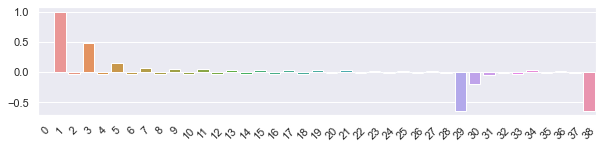

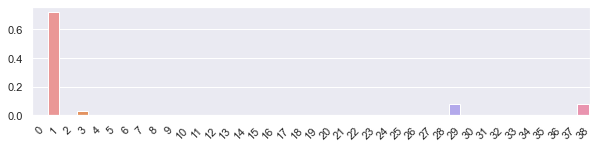

pivot 1
conjecture:
+: set()
--------------
-: {()}
data


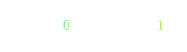

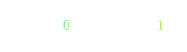

===========1================
size 18.0
energy 23.576167386173868
surprisal 23.21616738617387


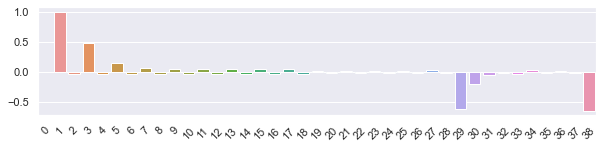

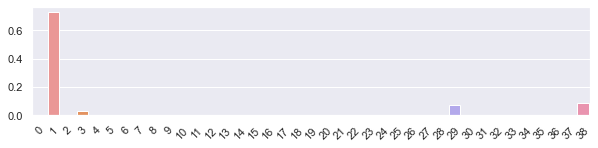

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red')}
data


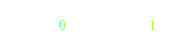

===========2================
size 18.0
energy 23.576167386173868
surprisal 23.21616738617387


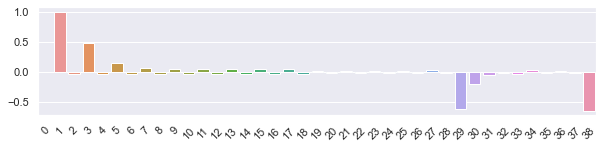

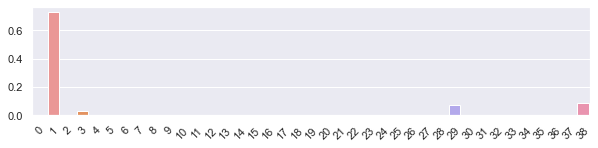

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'green', 'yellow')}
data


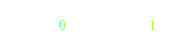

===========3================
size 30.0
energy 38.44079059390453
surprisal 37.84079059390453


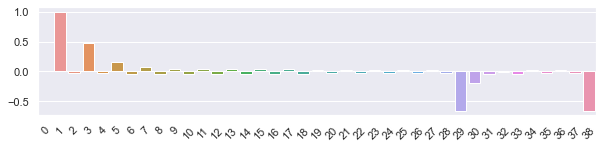

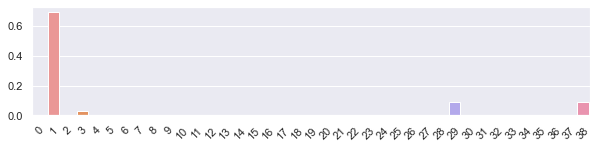

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


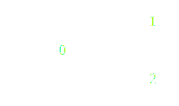

===========4================
size 30.0
energy 21.68734035870784
surprisal 21.087340358707838


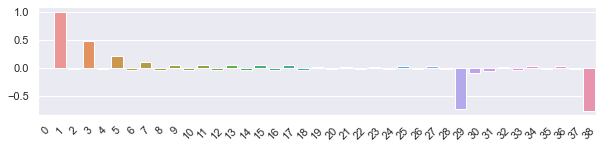

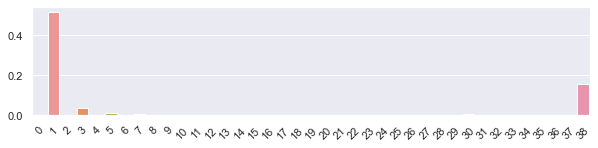

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


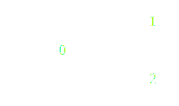

===========5================
size 30.841116916640328
energy 20.942098968083364
surprisal 20.325276629750558


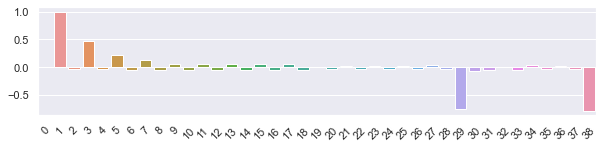

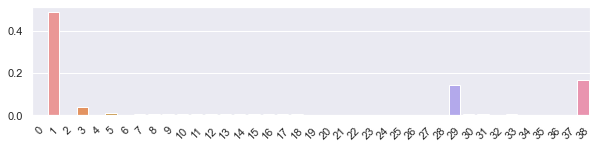

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'yellow')}
data


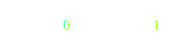

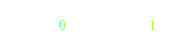

===========6================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


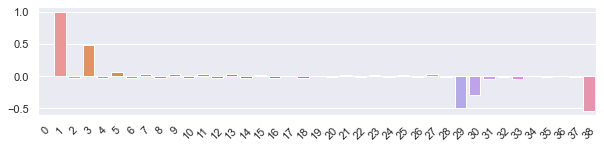

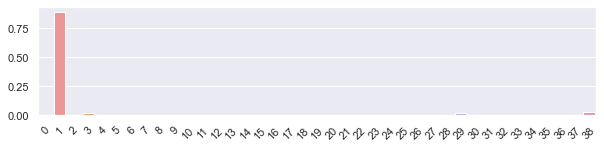

pivot 1
conjecture:
+: set()
--------------
-: {('red',)}
data


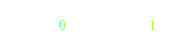

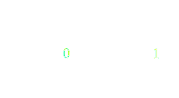

===========7================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


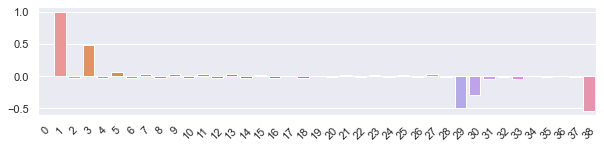

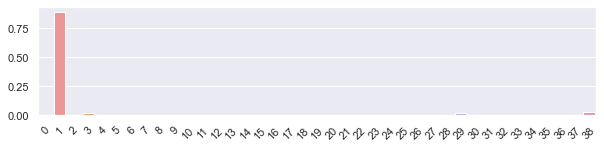

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red')}
data


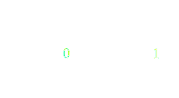

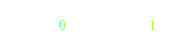

===========8================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


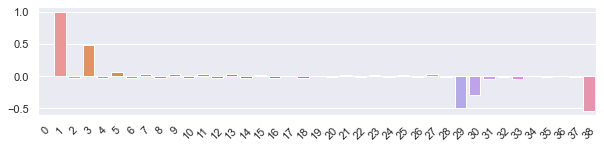

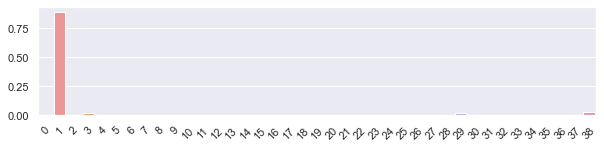

pivot 1
conjecture:
+: set()
--------------
-: {('red', 'yellow', 'green')}
data


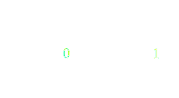

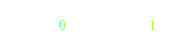

===========9================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


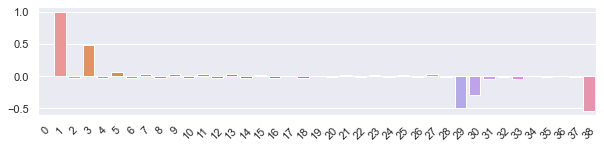

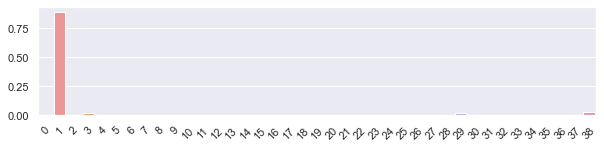

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'blue')}
data


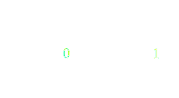

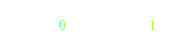

===========10================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


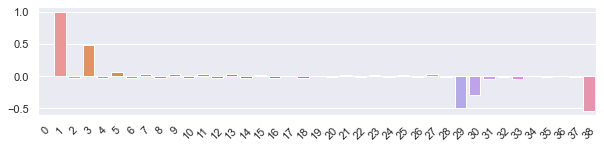

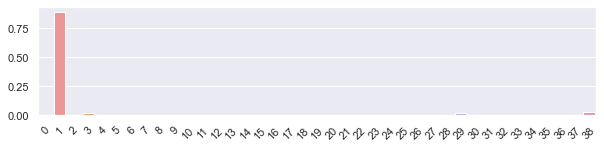

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red')}
data


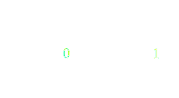

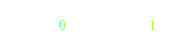

===========11================
size 42.84111691664033
energy 24.558819727290896
surprisal 23.701997388958087


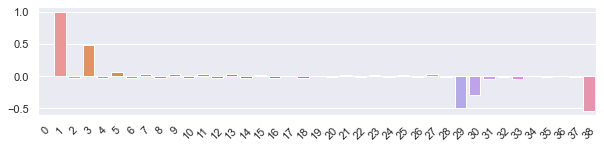

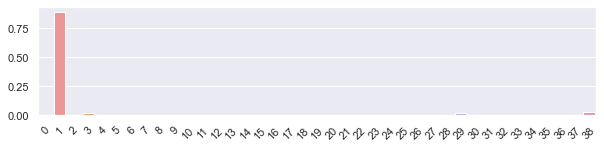

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'yellow', 'green', 'red')}
data


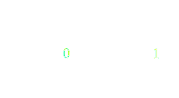

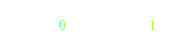

===========12================
size 46.84111691664033
energy 23.13311132798898
surprisal 22.196288989656175


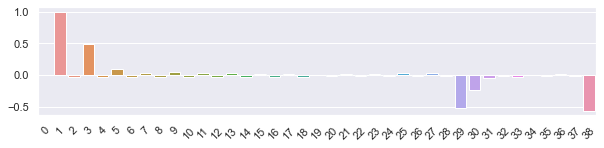

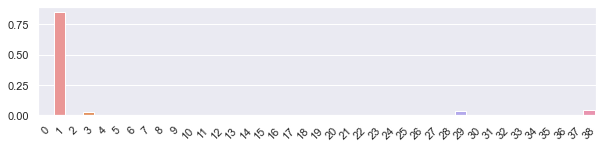

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'yellow')}
data


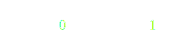

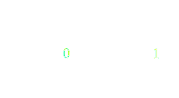

===========13================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


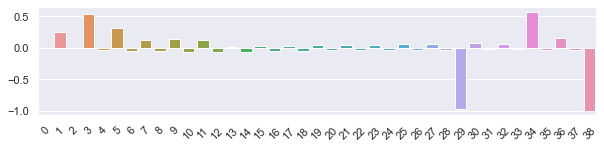

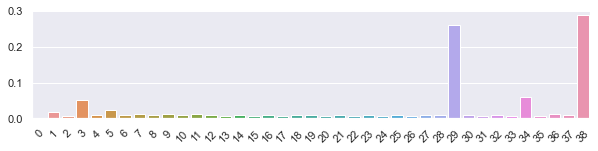

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


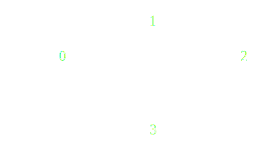

===========14================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


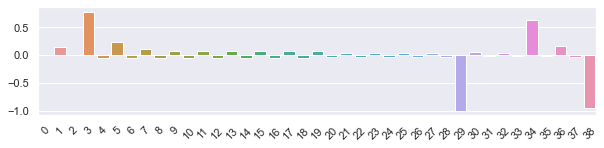

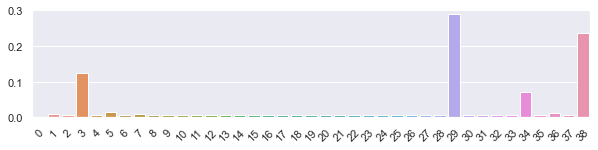

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


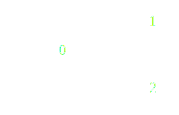

===========15================
size 48.0
energy 25.77625070772329
surprisal 24.816250707723288


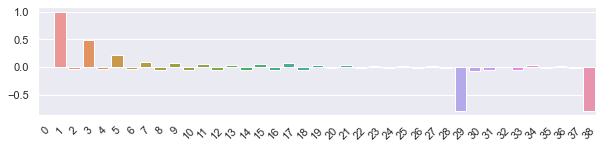

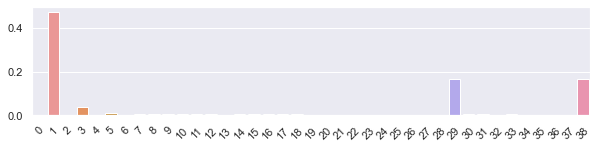

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'green')}
data


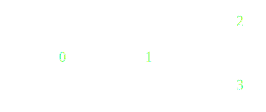

===========16================
size 48.0
energy 14.333893320412532
surprisal 13.373893320412531


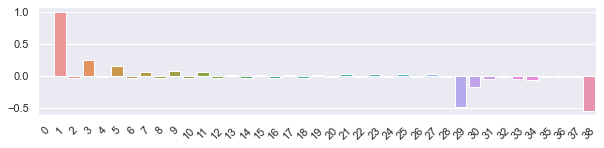

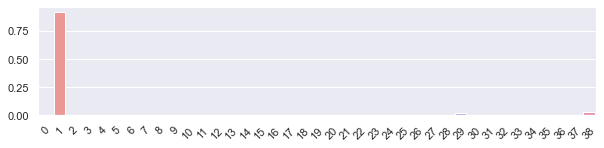

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'blue')}
data


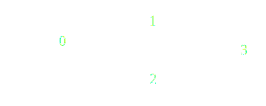

===========17================
size 48.0
energy 14.333893320412532
surprisal 13.373893320412531


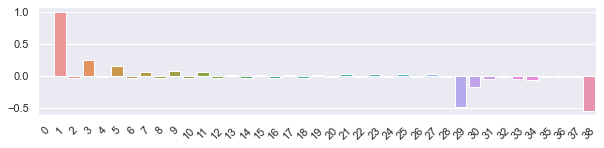

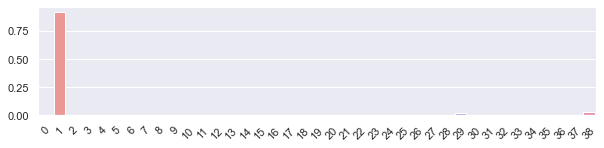

pivot 1
conjecture:
+: set()
--------------
-: {('red', 'blue')}
data


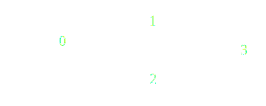

===========18================
size 48.0
energy 14.333893320412532
surprisal 13.373893320412531


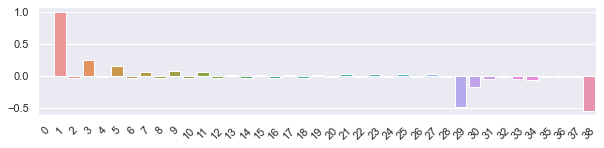

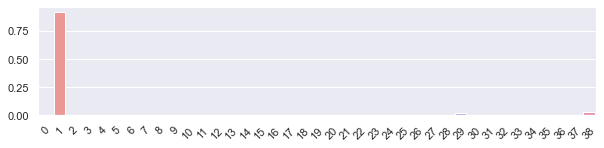

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red', 'yellow', 'red')}
data


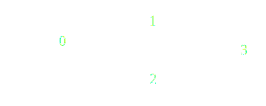

===========19================
size 48.0
energy 14.767186173835167
surprisal 13.807186173835166


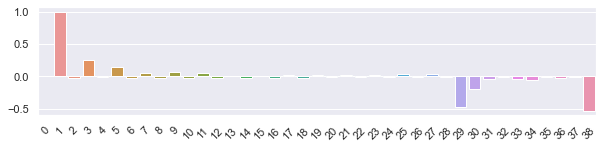

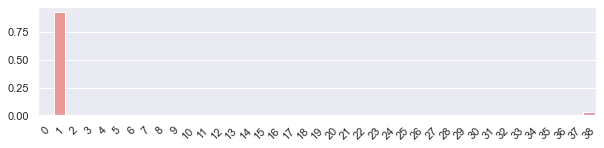

pivot 1
conjecture:
+: set()
--------------
-: {('red', 'blue', 'red')}
data


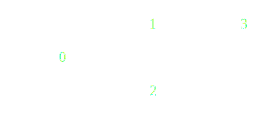

===========20================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


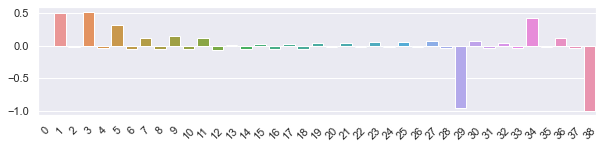

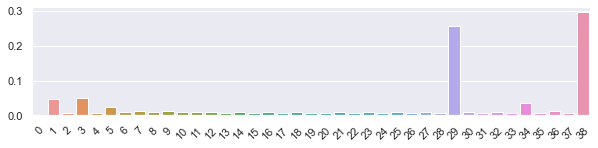

pivot 22
conjecture:
+: {('blue', 'green')}
--------------
-: set()
data


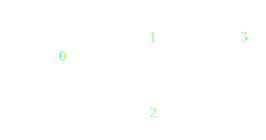

===========21================
size 48.0
energy 22.321333766237355
surprisal 21.361333766237355


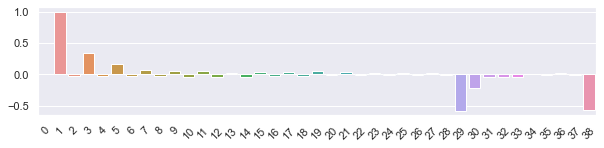

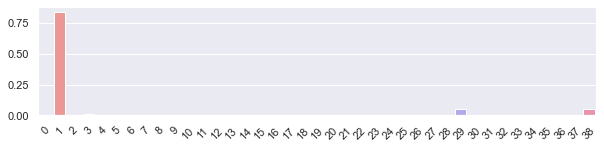

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'green')}
data


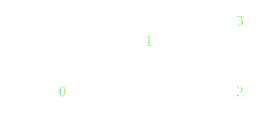

===========22================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


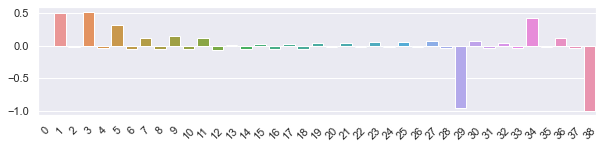

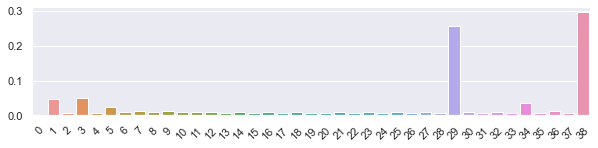

pivot 33
conjecture:
+: {()}
--------------
-: set()
data


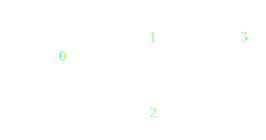

===========23================
size 48.0
energy 9.364906951180192
surprisal 8.404906951180191


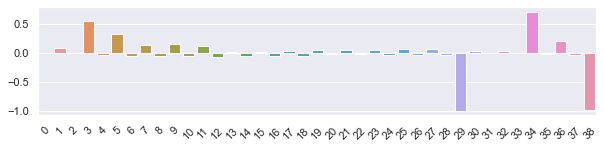

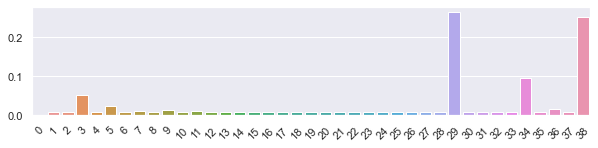

pivot 38
conjecture:
+: {('yellow', 'blue')}
--------------
-: set()
data


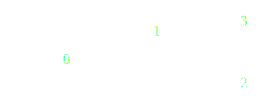

===========24================
size 54.84111691664033
energy 27.207931489278348
surprisal 26.11110915094554


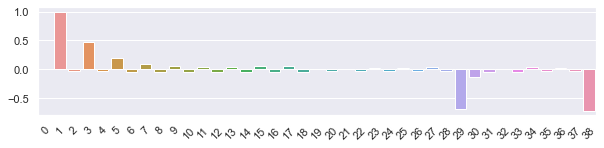

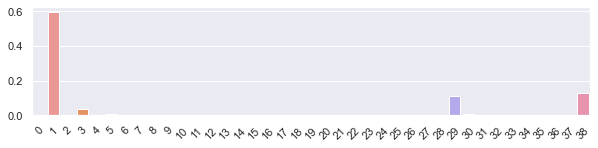

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


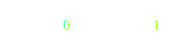

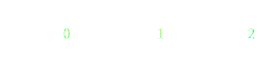

===========25================
size 54.84111691664033
energy 26.89144137145219
surprisal 25.794619033119382


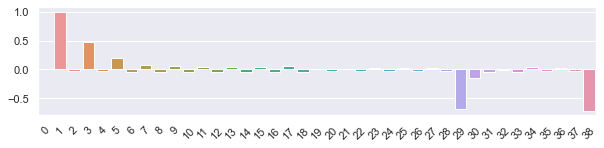

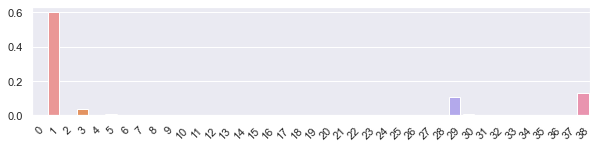

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


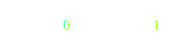

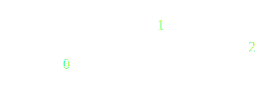

===========26================
size 56.84111691664033
energy 10.105488987027158
surprisal 8.968666648694352


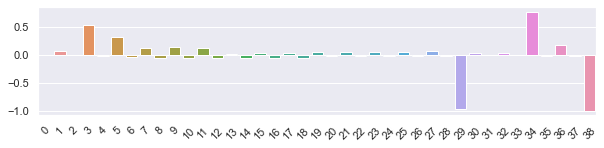

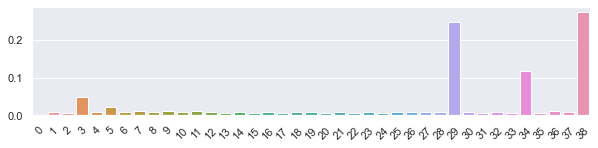

pivot 34
conjecture:
+: set()
--------------
-: {()}
data


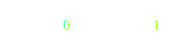

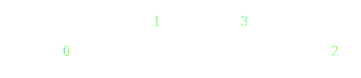

===========27================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


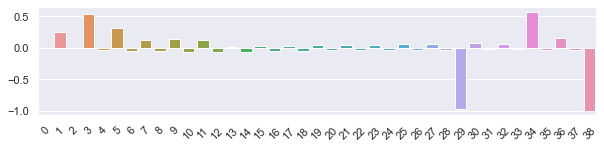

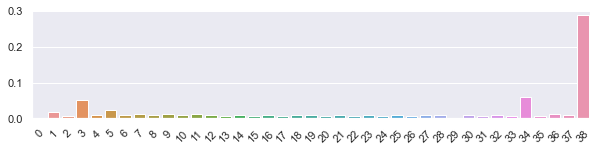

pivot 36
conjecture:
+: set()
--------------
-: {('yellow',)}
data


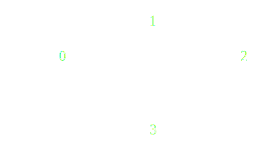

===========28================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


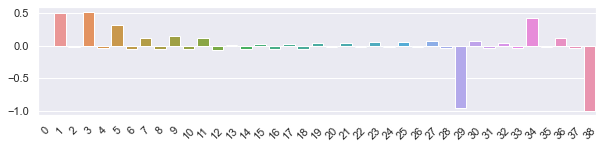

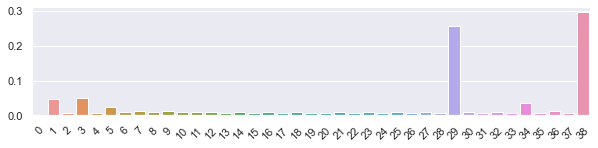

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


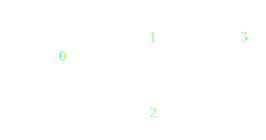

===========29================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


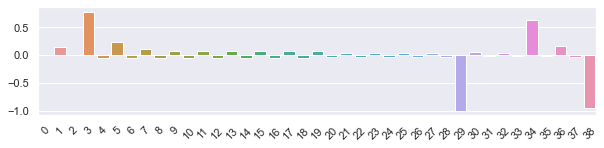

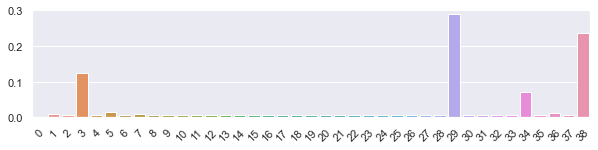

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


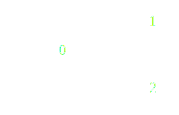

===========30================
size 56.84111691664033
energy 10.105488987027158
surprisal 8.968666648694352


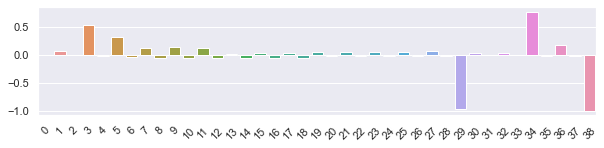

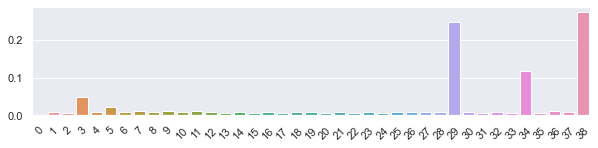

pivot 38
conjecture:
+: {('yellow', 'blue')}
--------------
-: set()
data


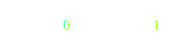

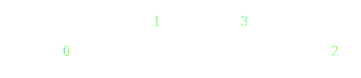

===========31================
size 56.84111691664033
energy 10.105488987027158
surprisal 8.968666648694352


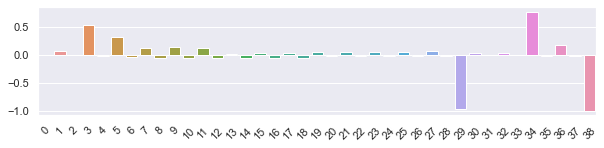

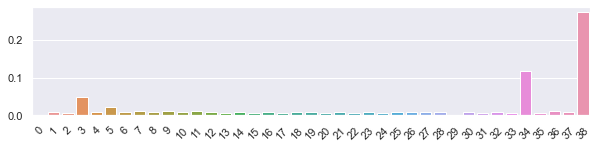

pivot 38
conjecture:
+: {('yellow', 'green')}
--------------
-: set()
data


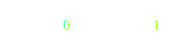

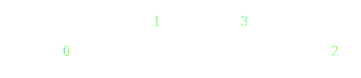

===========32================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


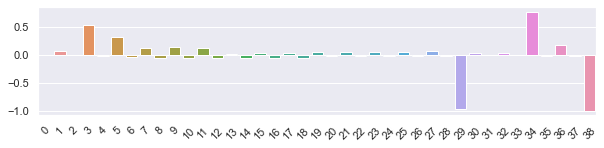

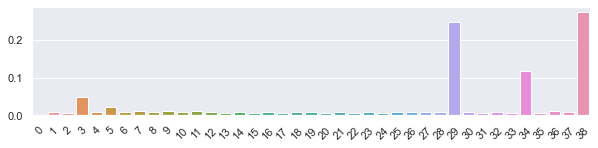

pivot 21
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


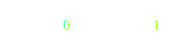

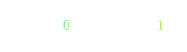

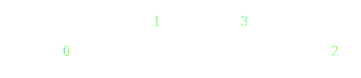

===========33================
size 42.84111691664033
energy 21.949387714204292
surprisal 21.092565375871484


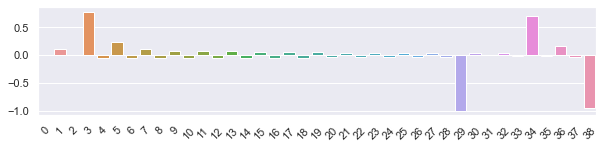

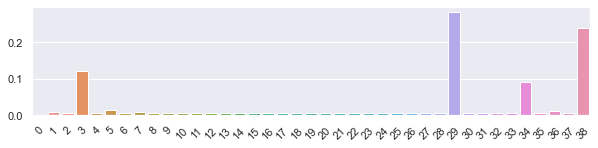

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


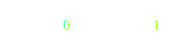

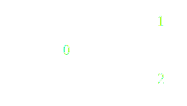

===========34================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


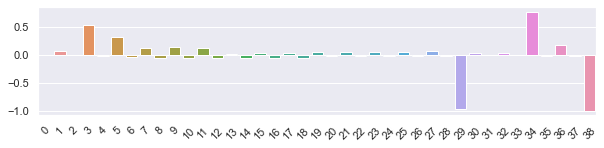

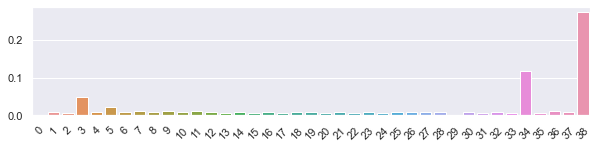

pivot 5
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


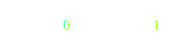

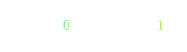

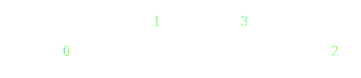

===========35================
size 42.84111691664033
energy 21.949387714204292
surprisal 21.092565375871484


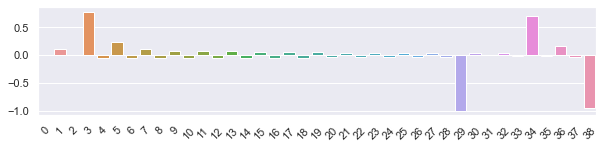

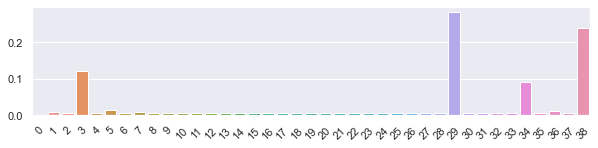

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


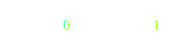

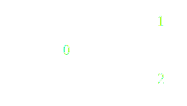

===========36================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


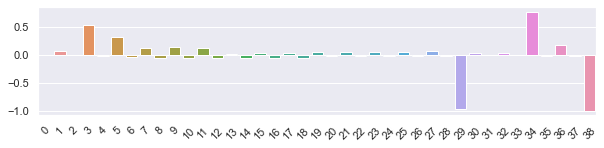

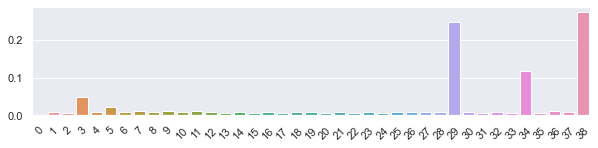

pivot 8
conjecture:
+: {('blue',)}
--------------
-: set()
data


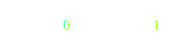

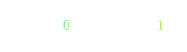

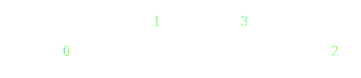

===========37================
size 59.682233833280655
energy 26.988263709784995
surprisal 25.794619033119382


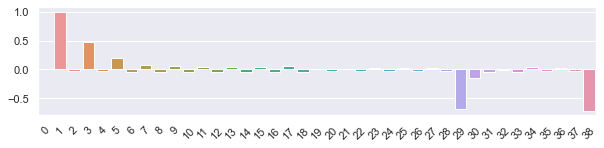

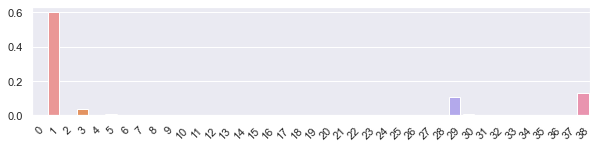

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


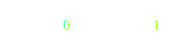

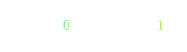

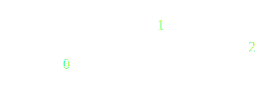

===========38================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


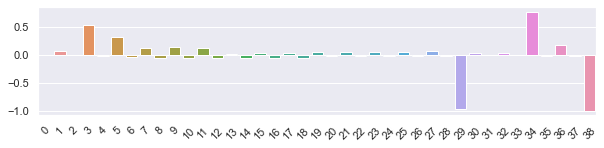

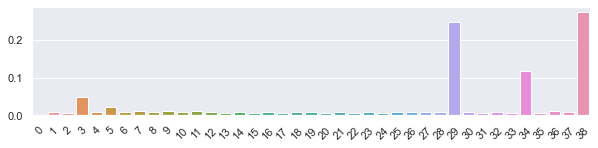

pivot 19
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


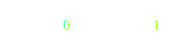

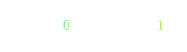

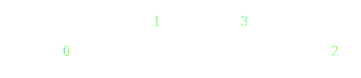

===========39================
size 45.682233833280655
energy 22.060626974251946
surprisal 21.146982297586334


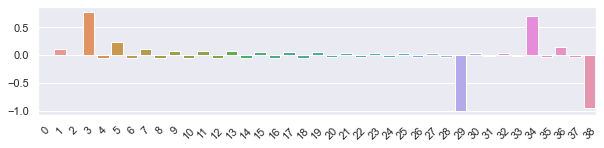

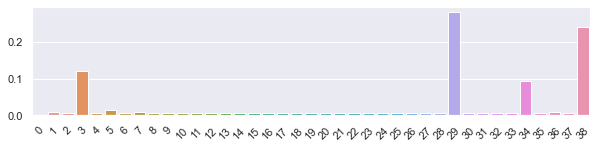

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


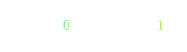

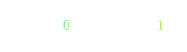

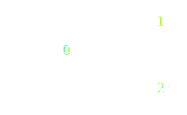

===========40================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


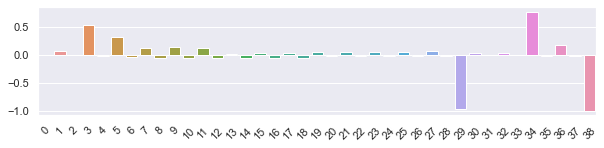

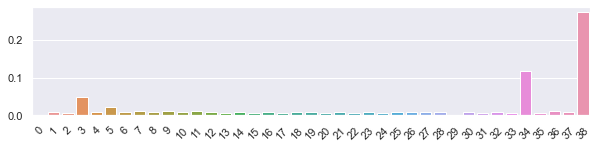

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


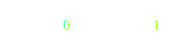

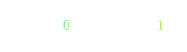

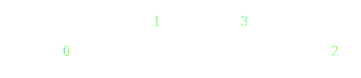

===========41================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


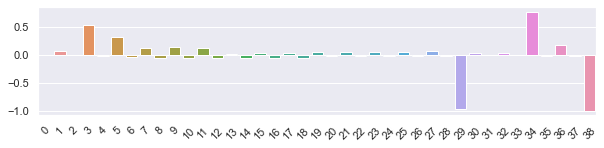

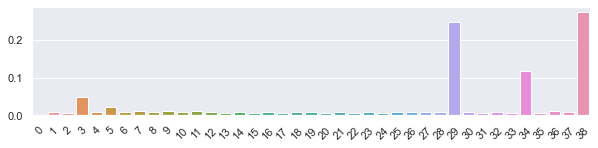

pivot 34
conjecture:
+: set()
--------------
-: {()}
data


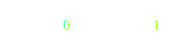

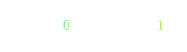

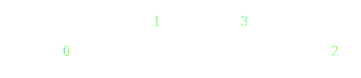

===========42================
size 48.84111691664033
energy 9.127367809412915
surprisal 8.150545471080108


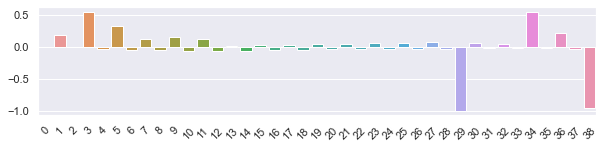

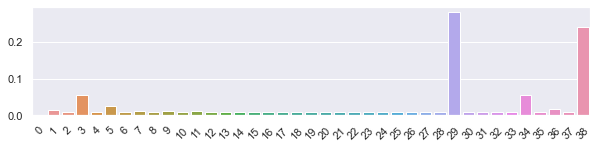

pivot 19
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


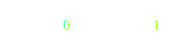

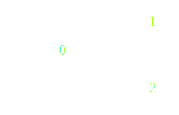

===========43================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


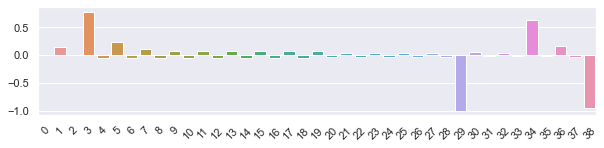

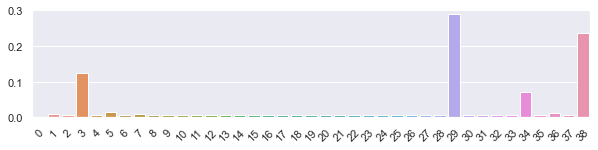

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


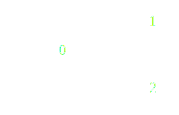

===========44================
size 48.84111691664033
energy 9.127367809412915
surprisal 8.150545471080108


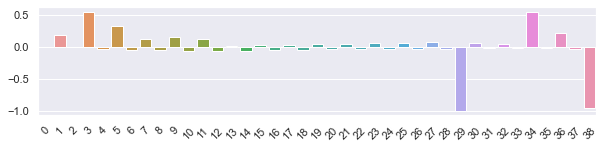

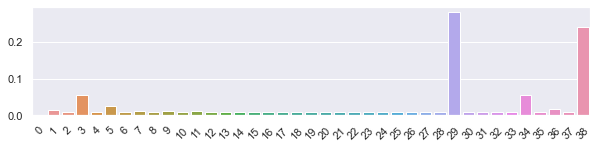

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


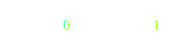

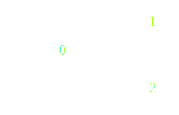

===========45================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


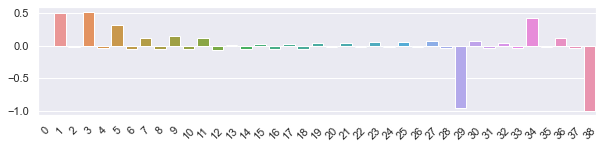

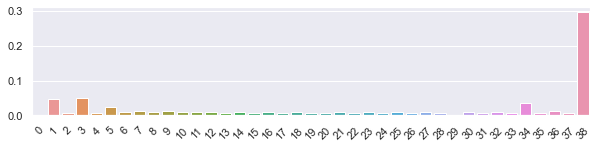

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


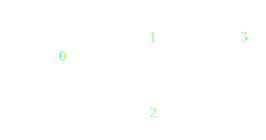

===========46================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


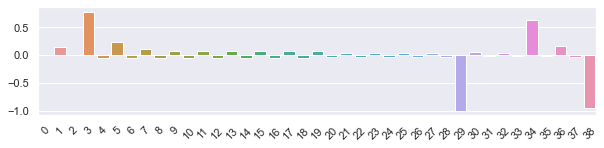

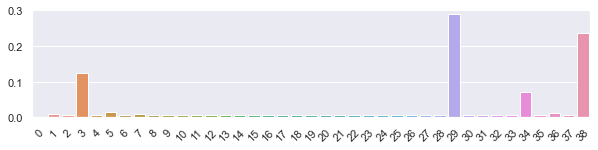

pivot 34
conjecture:
+: set()
--------------
-: {('yellow',)}
data


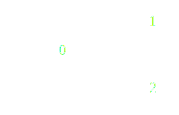

===========47================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


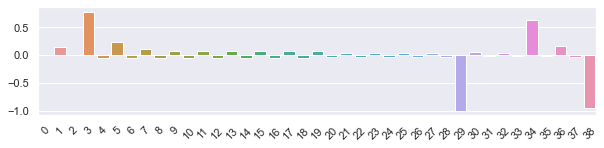

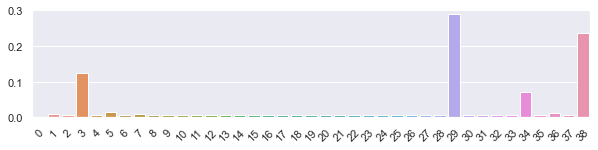

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


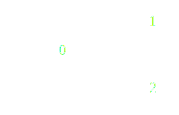

===========48================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


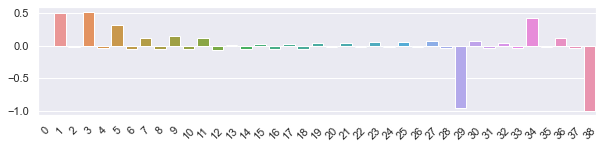

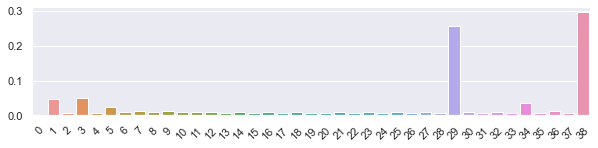

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


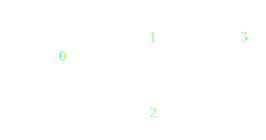

===========49================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


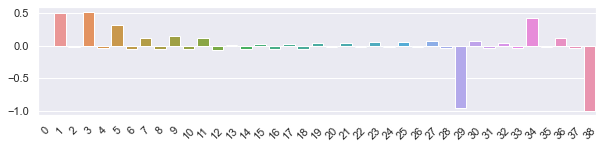

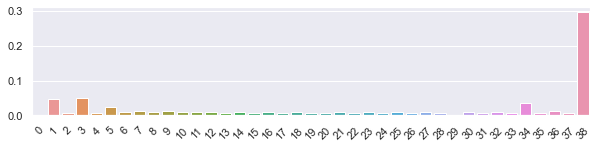

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


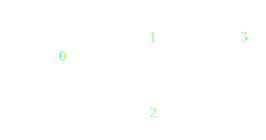

===========50================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


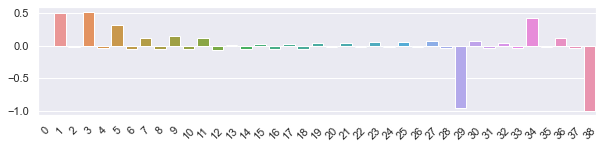

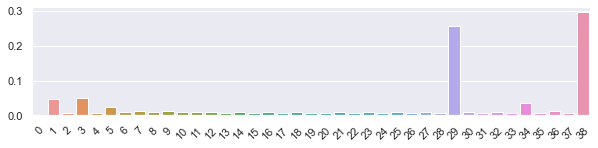

pivot 9
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


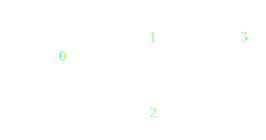

===========51================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


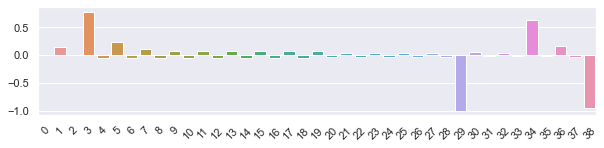

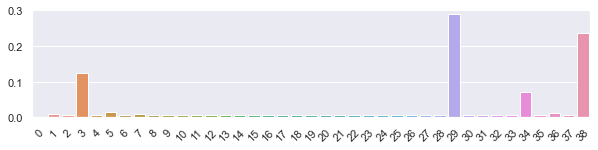

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


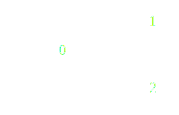

===========52================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


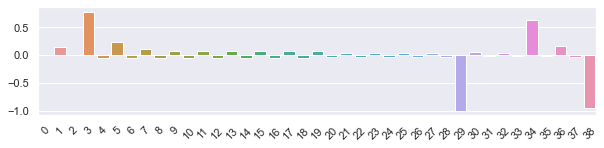

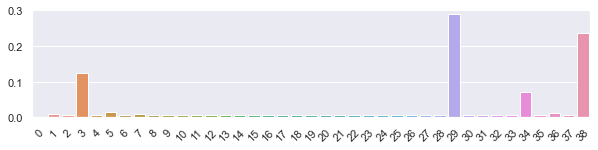

pivot 16
conjecture:
+: {('blue',)}
--------------
-: set()
data


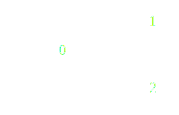

===========53================
size 56.0
energy 44.349204735064724
surprisal 43.22920473506473


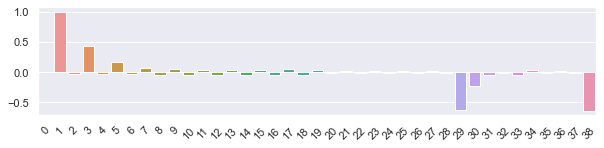

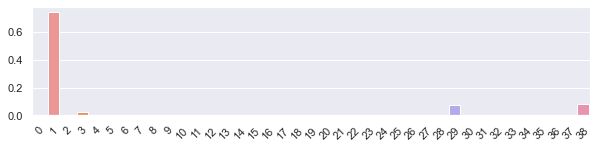

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


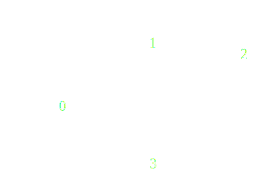

===========54================
size 56.0
energy 44.36073774576702
surprisal 43.24073774576702


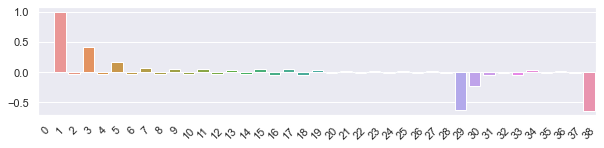

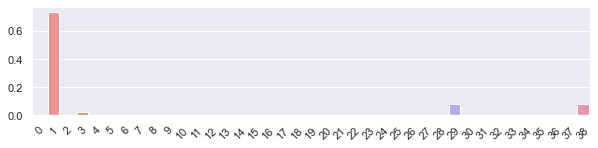

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'red')}
data


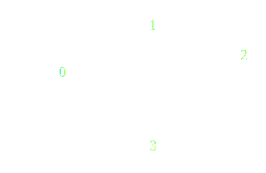

===========55================
size 56.0
energy 44.36073774576702
surprisal 43.24073774576702


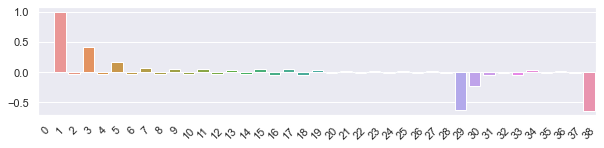

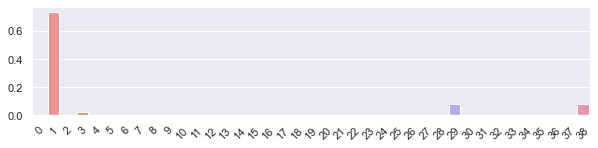

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


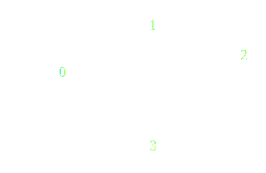

===========56================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


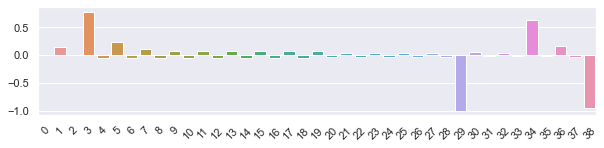

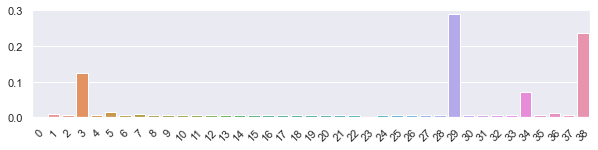

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


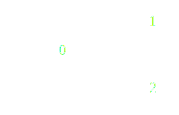

===========57================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


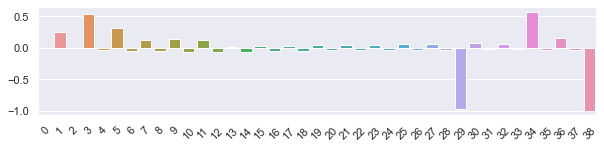

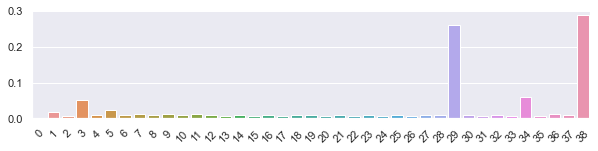

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


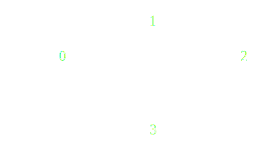

===========58================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


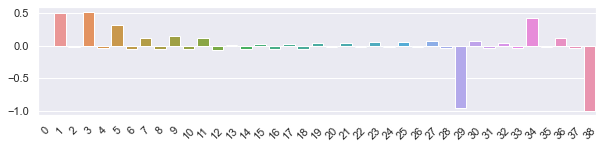

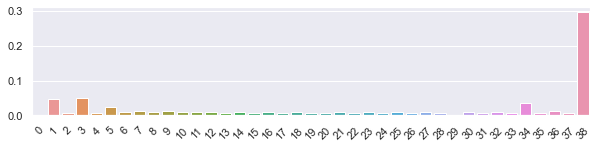

pivot 24
conjecture:
+: {('blue', 'green')}
--------------
-: set()
data


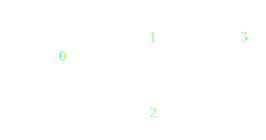

===========59================
size 48.0
energy 25.77625070772329
surprisal 24.816250707723288


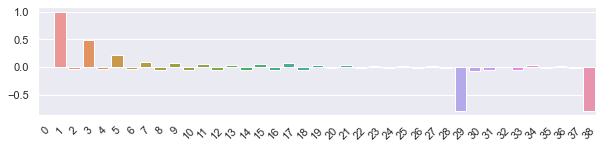

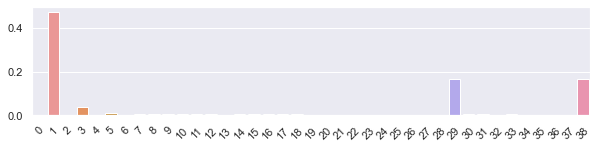

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'green')}
data


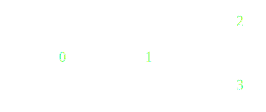

===========60================
size 61.682233833280655
energy 10.202311325359965
surprisal 8.968666648694352


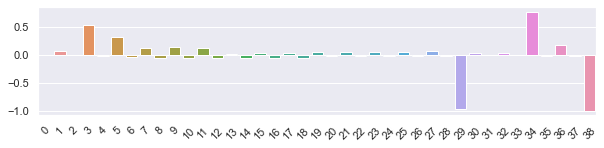

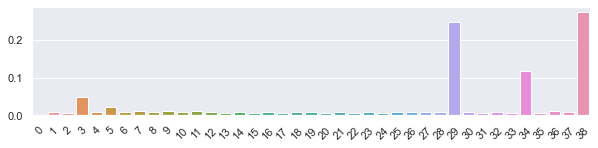

pivot 34
conjecture:
+: set()
--------------
-: {()}
data


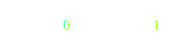

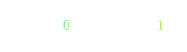

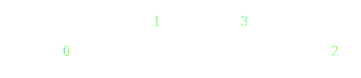

===========61================
size 48.84111691664033
energy 9.127367809412915
surprisal 8.150545471080108


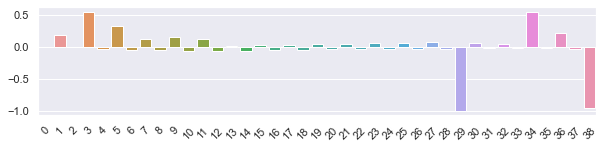

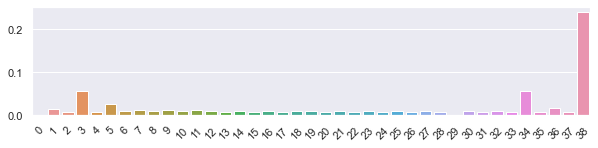

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


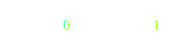

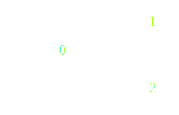

===========62================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


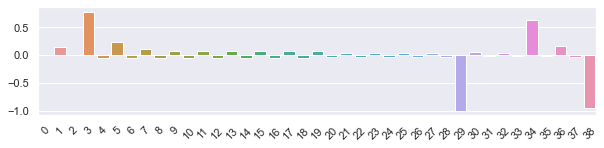

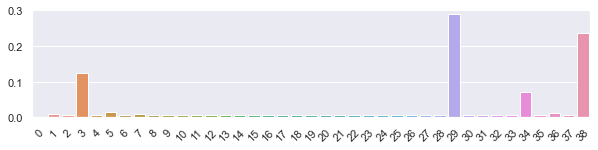

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


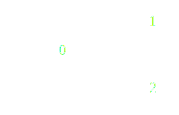

===========63================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


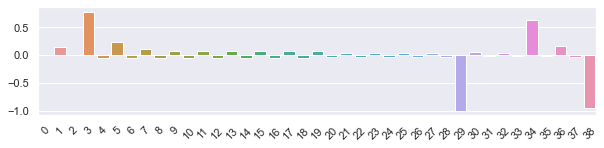

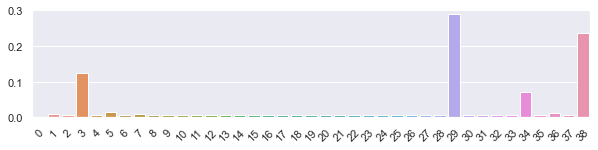

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


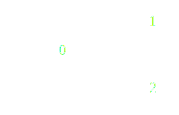

===========64================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


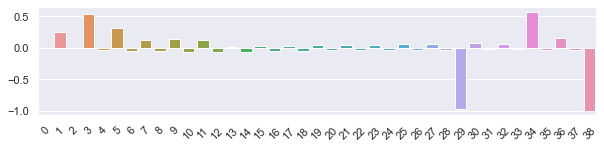

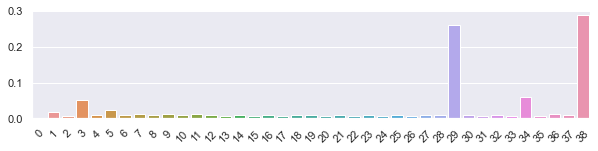

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


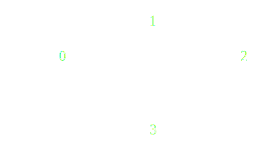

===========65================
size 36.0
energy 21.674004838682187
surprisal 20.954004838682188


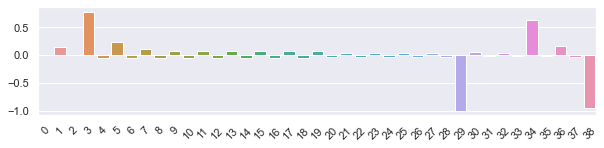

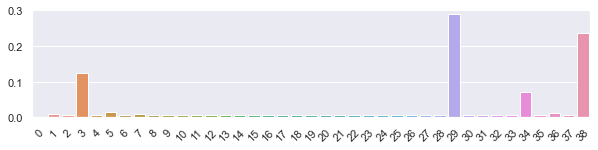

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


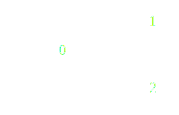

===========66================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


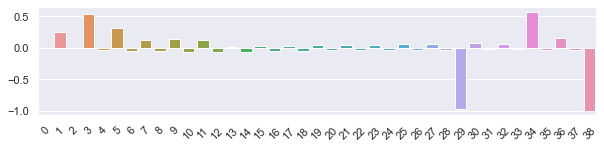

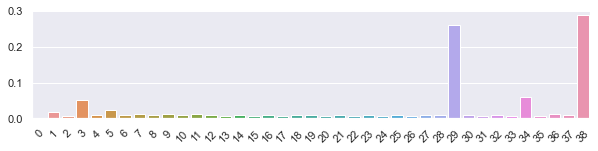

pivot 37
conjecture:
+: {('yellow',)}
--------------
-: set()
data


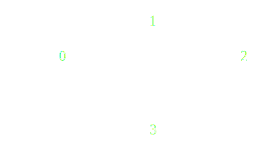

===========67================
size 48.0
energy 9.998506517913473
surprisal 9.038506517913474


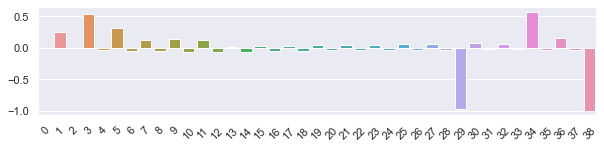

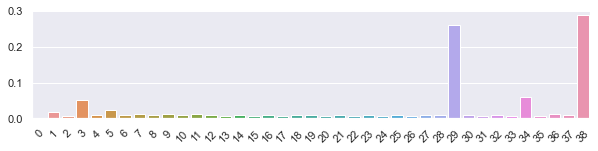

pivot 6
conjecture:
+: {('blue',)}
--------------
-: set()
data


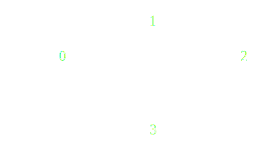

===========68================
size 54.84111691664033
energy 29.555532228559812
surprisal 28.458709890227006


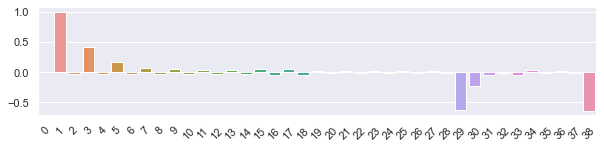

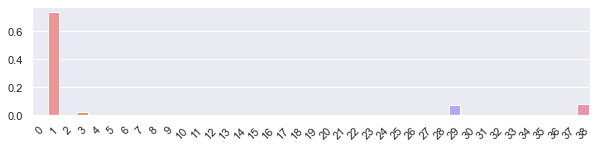

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


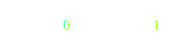

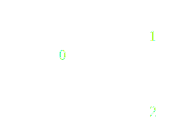

===========69================
size 48.0
energy 10.298179434218795
surprisal 9.338179434218794


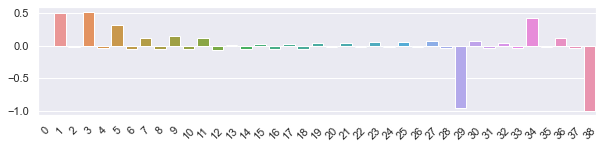

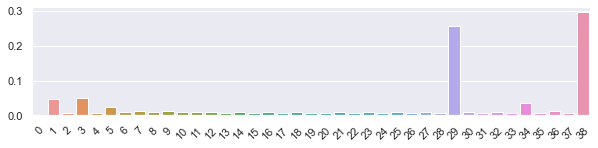

pivot 32
conjecture:
+: set()
--------------
-: {('yellow',)}
data


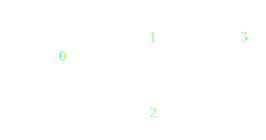

===========70================
size 48.84111691664033
energy 9.127367809412915
surprisal 8.150545471080108


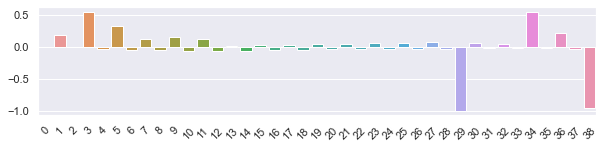

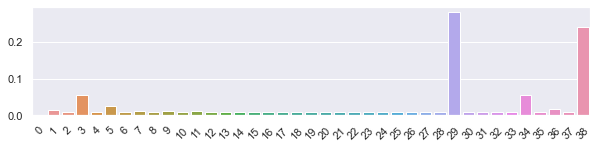

pivot 36
conjecture:
+: set()
--------------
-: {('yellow', 'blue')}
data


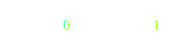

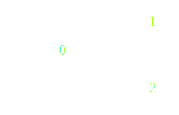

===========71================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


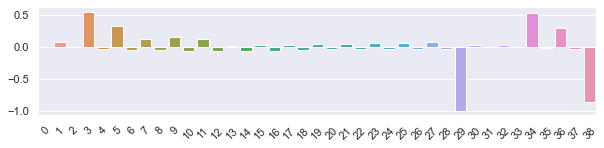

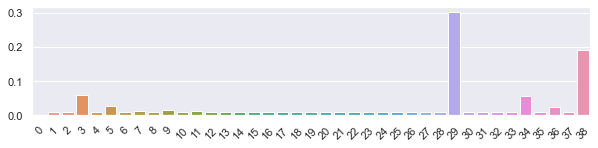

pivot 23
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


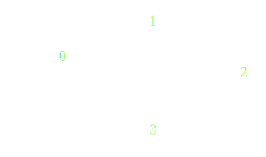

===========72================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


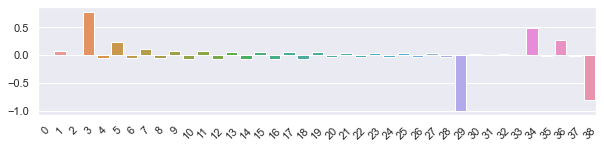

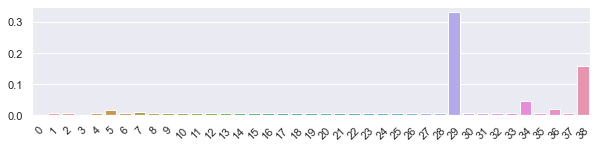

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


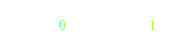

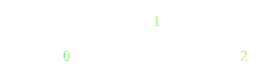

===========73================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


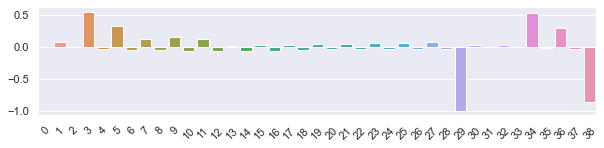

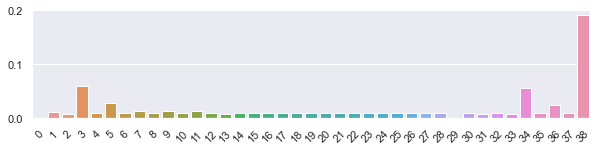

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


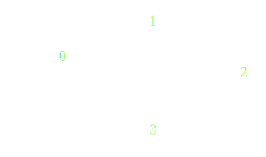

===========74================
size 54.0
energy 8.86030310315184
surprisal 7.780303103151841


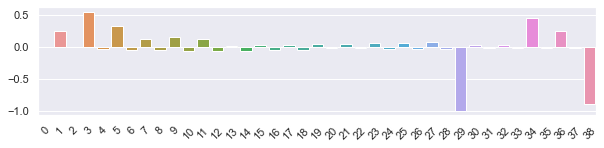

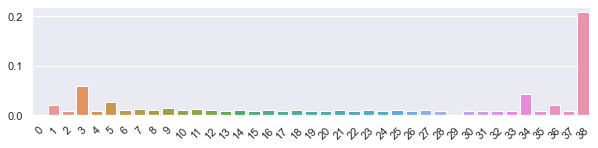

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


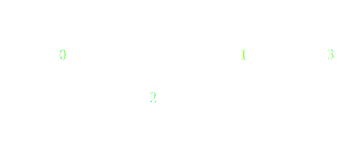

===========75================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


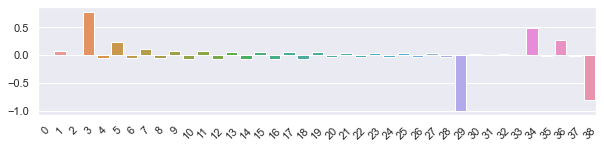

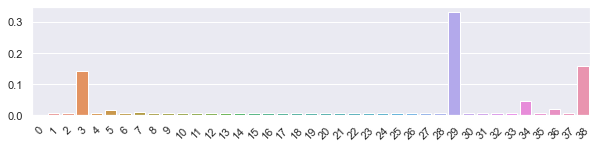

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


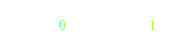

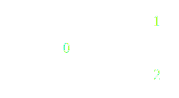

===========76================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


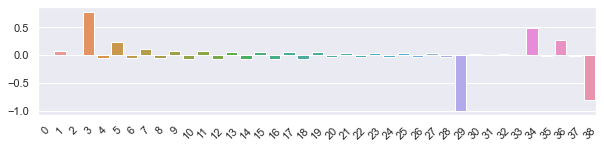

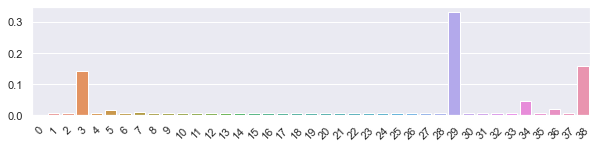

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


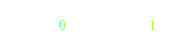

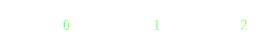

===========77================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


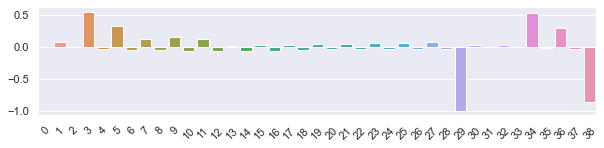

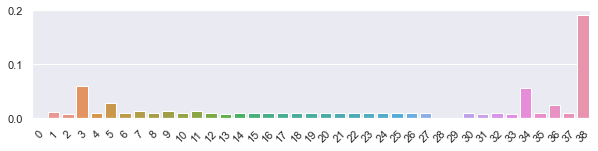

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


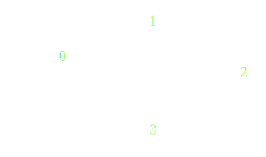

===========78================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


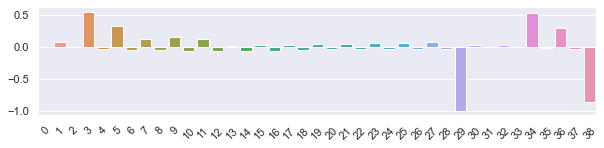

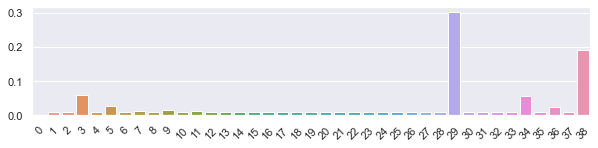

pivot 12
conjecture:
+: {('blue', 'yellow')}
--------------
-: set()
data


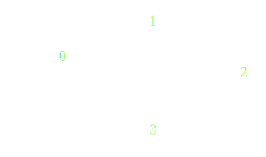

===========79================
size 36.0
energy 20.99448756076327
surprisal 20.274487560763273


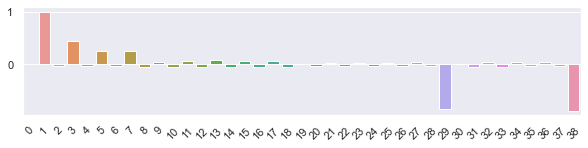

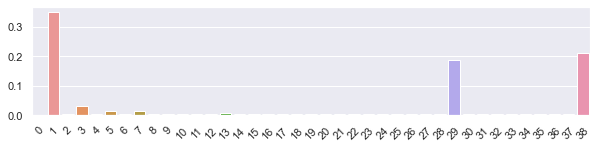

pivot 1
conjecture:
+: set()
--------------
-: {('blue', 'yellow')}
data


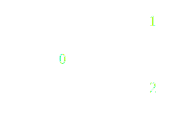

===========80================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


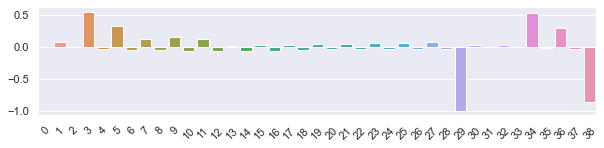

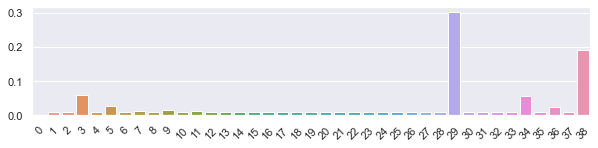

pivot 8
conjecture:
+: {('blue', 'yellow')}
--------------
-: set()
data


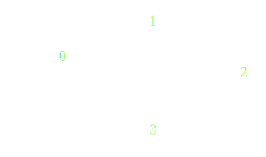

===========81================
size 36.0
energy 20.99448756076327
surprisal 20.274487560763273


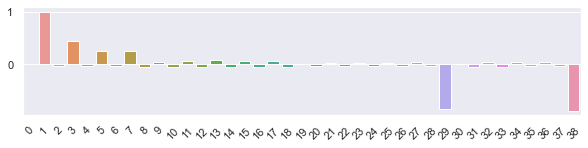

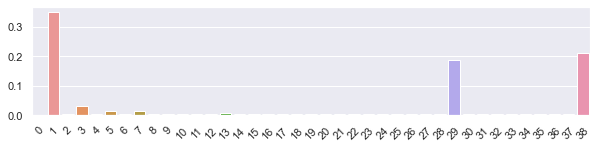

pivot 5
conjecture:
+: set()
--------------
-: {('blue', 'yellow')}
data


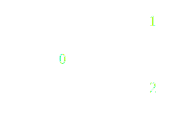

===========82================
size 54.84111691664033
energy 8.705581930590327
surprisal 7.60875959225752


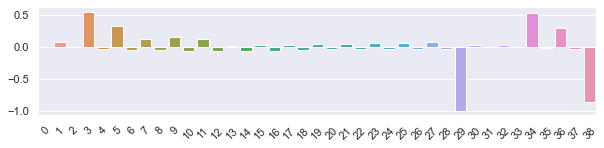

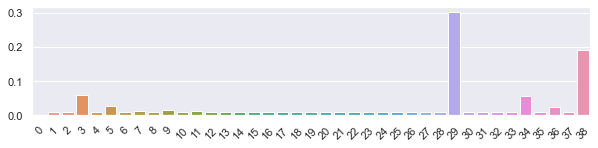

pivot 4
conjecture:
+: {('blue',)}
--------------
-: set()
data


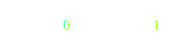

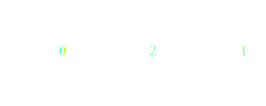

===========83================
size 62.0
energy 28.705159214369033
surprisal 27.465159214369034


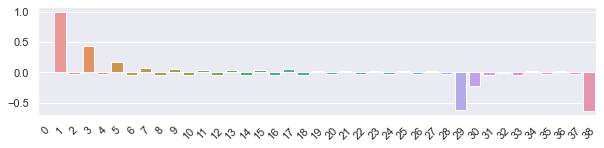

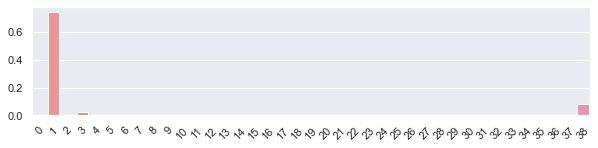

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


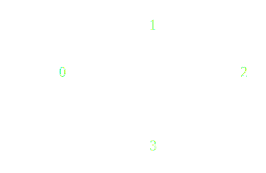

===========84================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


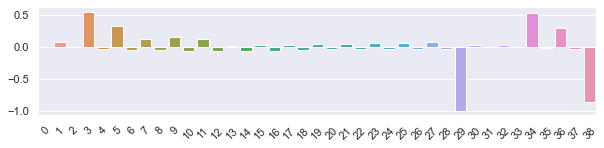

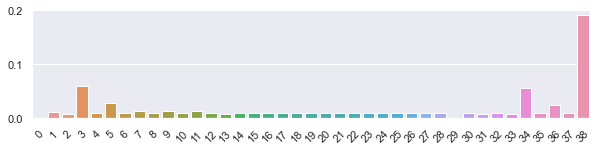

pivot 8
conjecture:
+: {('blue',)}
--------------
-: set()
data


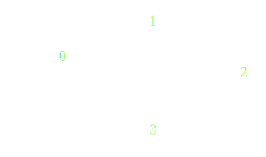

===========85================
size 62.0
energy 28.72083083051768
surprisal 27.480830830517682


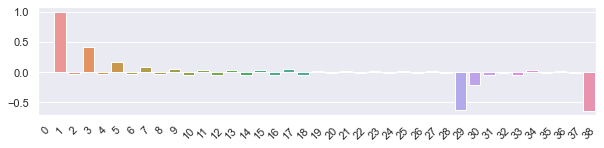

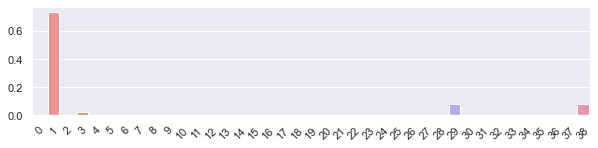

pivot 1
conjecture:
+: set()
--------------
-: {('blue',)}
data


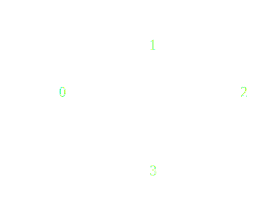

===========86================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


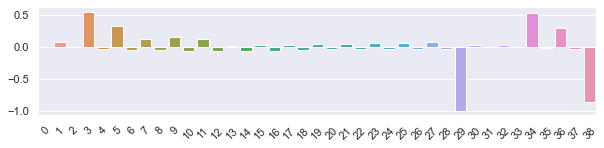

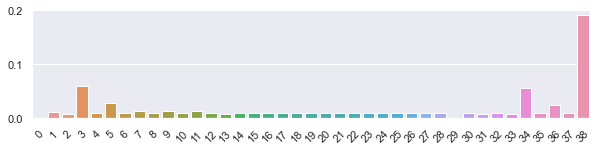

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


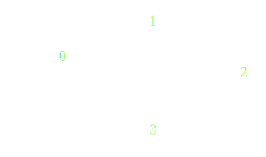

===========87================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


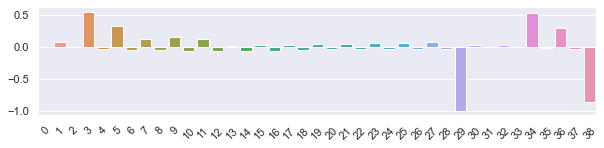

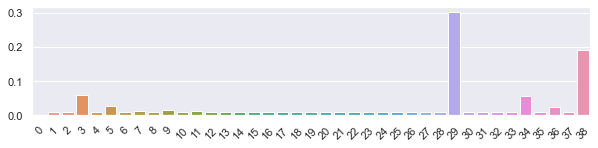

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


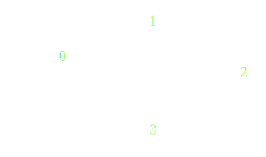

===========88================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


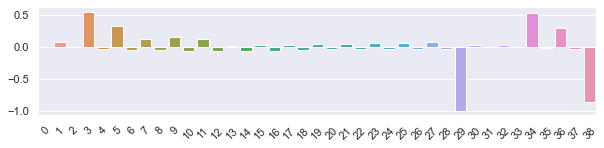

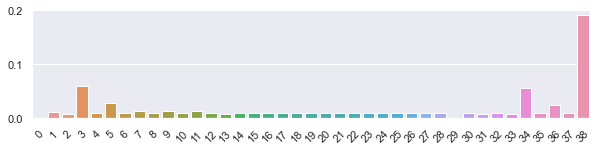

pivot 1
conjecture:
+: set()
--------------
-: {('yellow',)}
data


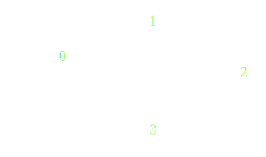

===========89================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


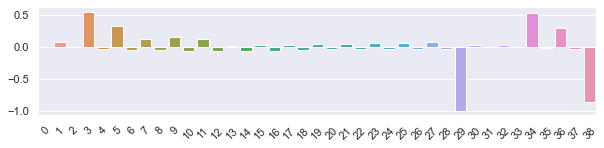

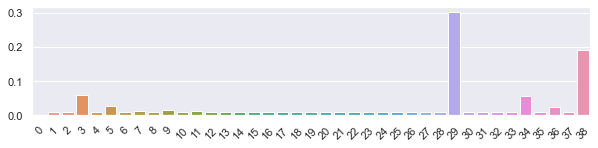

pivot 6
conjecture:
+: {('blue',)}
--------------
-: set()
data


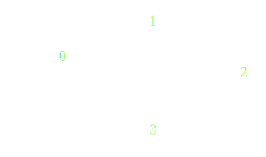

===========90================
size 54.84111691664033
energy 8.705581930590327
surprisal 7.60875959225752


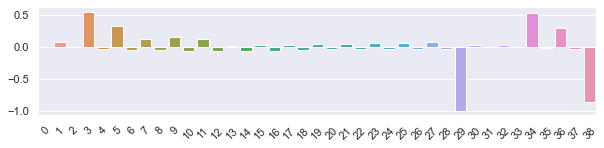

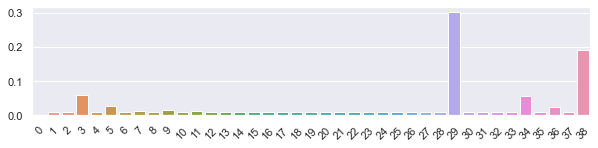

pivot 3
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


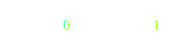

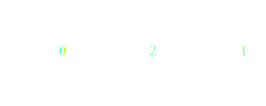

===========91================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


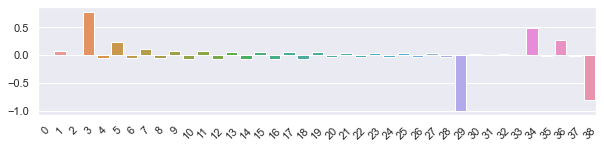

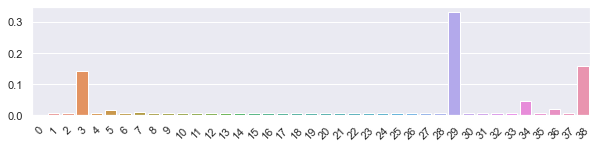

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


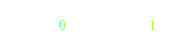

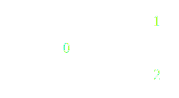

===========92================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


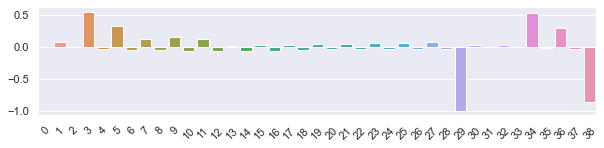

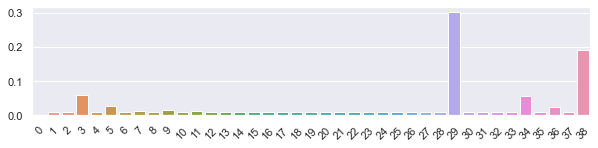

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


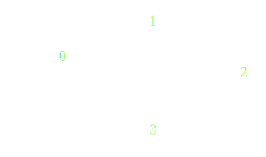

===========93================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


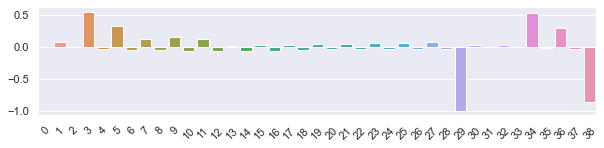

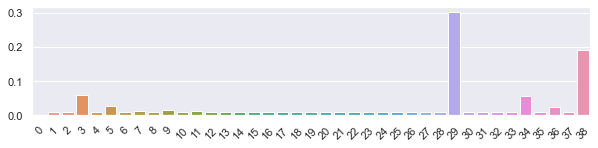

pivot 38
conjecture:
+: {('yellow',)}
--------------
-: set()
data


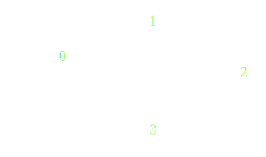

===========94================
size 54.84111691664033
energy 11.659543510271364
surprisal 10.562721171938557


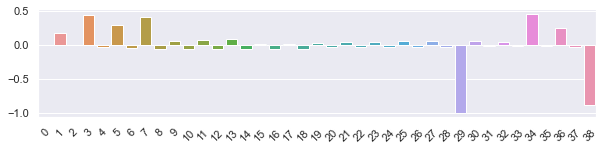

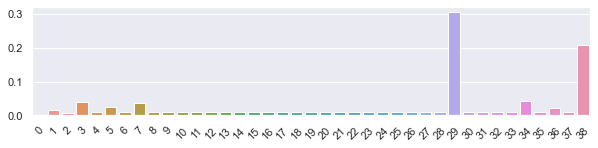

pivot 34
conjecture:
+: set()
--------------
-: {('yellow',)}
data


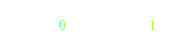

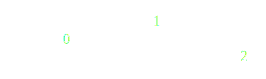

===========95================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


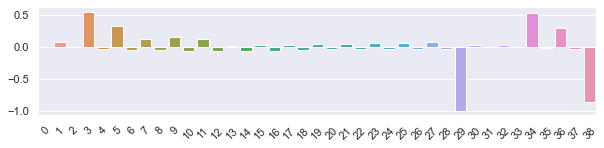

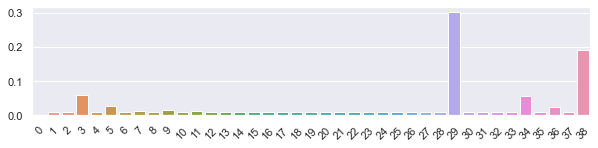

pivot 13
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


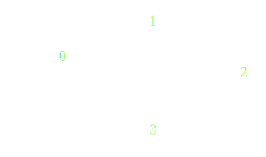

===========96================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


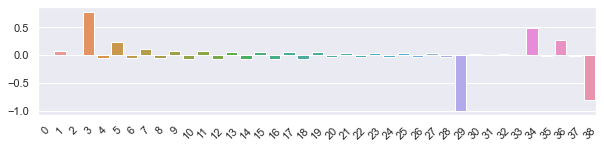

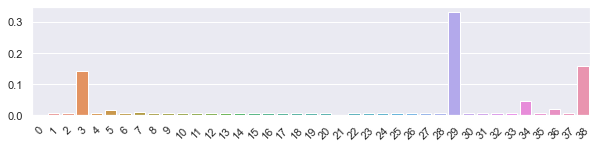

pivot 29
conjecture:
+: {('blue', 'green', 'yellow')}
--------------
-: set()
data


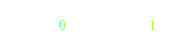

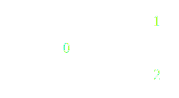

===========97================
size 54.84111691664033
energy 11.659543510271364
surprisal 10.562721171938557


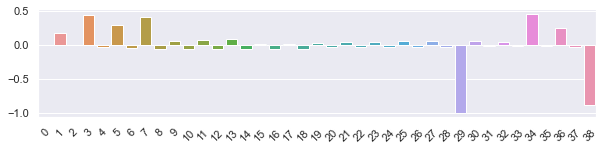

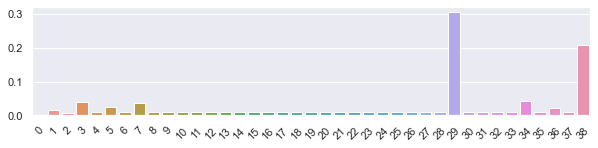

pivot 27
conjecture:
+: set()
--------------
-: {('blue', 'green', 'yellow')}
data


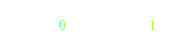

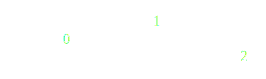

===========98================
size 34.84111691664033
energy 20.38372984158552
surprisal 19.686907503252712


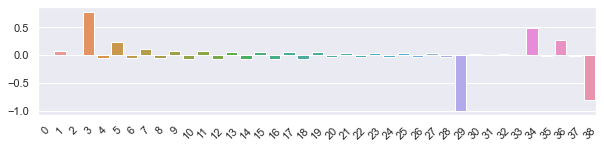

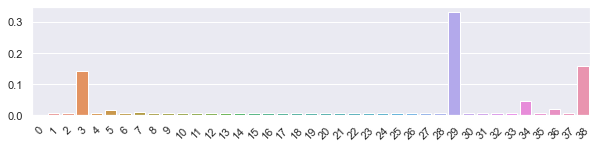

pivot 18
conjecture:
+: {('blue', 'green')}
--------------
-: set()
data


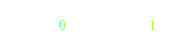

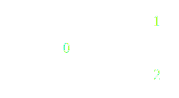

===========99================
size 54.0
energy 8.688912070378437
surprisal 7.608912070378437


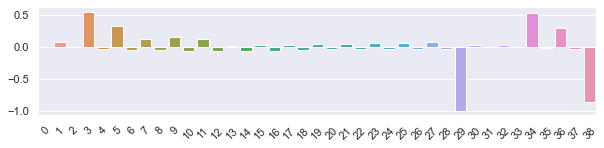

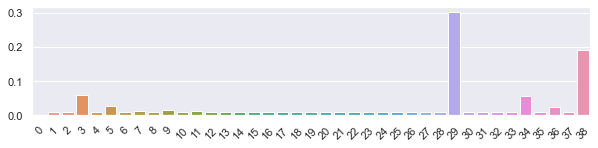

pivot 1
conjecture:
+: set()
--------------
-: {('yellow',)}
data


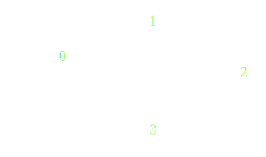

energy 8.688912070378437


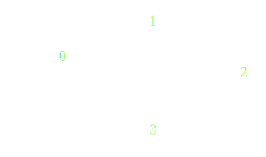

energy 8.705581930590327


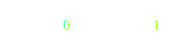

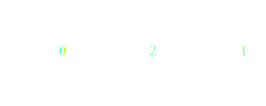

energy 8.86030310315184


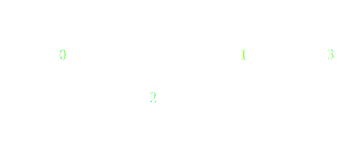

energy 9.127367809412915


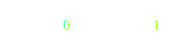

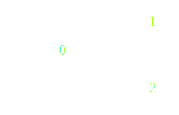

energy 9.364906951180192


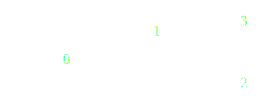

energy 9.998506517913473


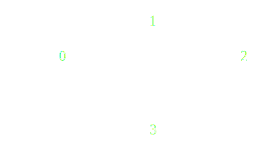

energy 10.105488987027158


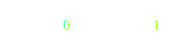

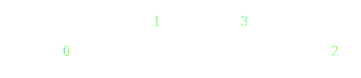

energy 10.202311325359965


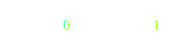

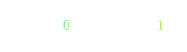

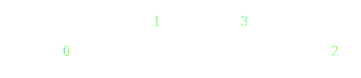

energy 10.298179434218795


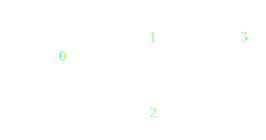

energy 11.659543510271364


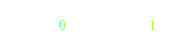

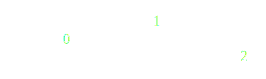

energy 14.333893320412532


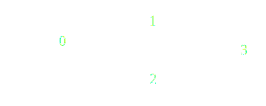

energy 14.767186173835167


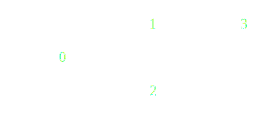

energy 20.38372984158552


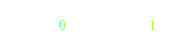

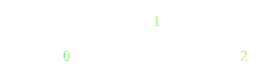

energy 20.942098968083364


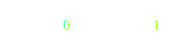

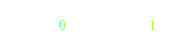

energy 20.99448756076327


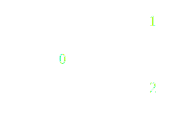

energy 21.674004838682187


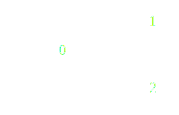

energy 21.68734035870784


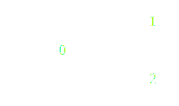

energy 21.949387714204292


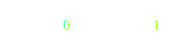

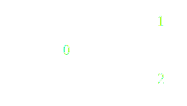

energy 22.060626974251946


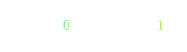

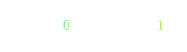

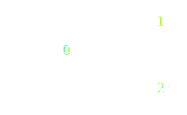

energy 22.321333766237355


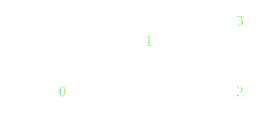

energy 23.13311132798898


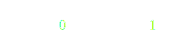

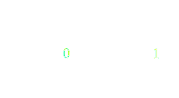

energy 23.576167386173868


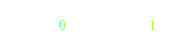

energy 24.558819727290896


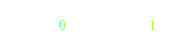

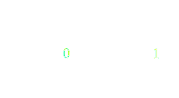

energy 24.558819727290896


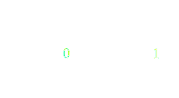

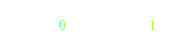

energy 25.77625070772329


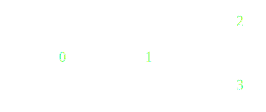

energy 26.636415199610727


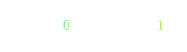

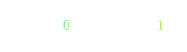

energy 26.89144137145219


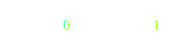

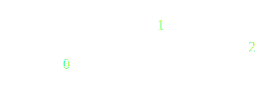

energy 26.988263709784995


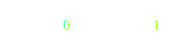

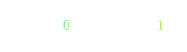

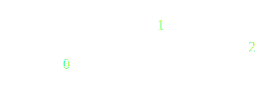

energy 27.207931489278348


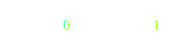

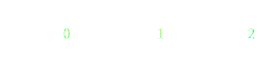

energy 28.705159214369033


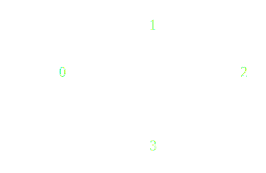

energy 28.72083083051768


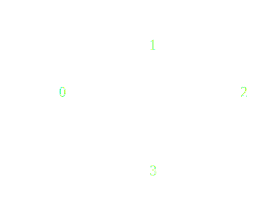

energy 29.555532228559812


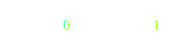

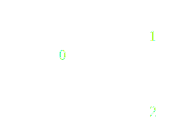

energy 38.44079059390453


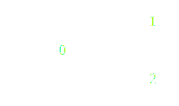

energy 44.349204735064724


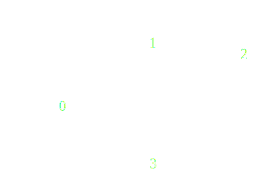

energy 44.36073774576702


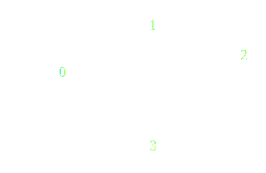

In [15]:
dfa_search = diss(
    demos=[to_demo(TRC4), to_demo(TRC5)] if MONOLITHIC else [to_demo(TRC4[:-1])],
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 10,
    lift_path=planner.lift_path,
    n_iters=n_iters,
    reset_period=30,
    surprise_weight=1,
    size_weight=1/50,
    sgs_temp=1/4,
    example_drop_prob=0, #1e-2,
    synth_timeout=0,
)

df, found_concepts = analyze(dfa_search, n_iters)

In [14]:
dfs = []
for i in fn.chain(range(-10, 11, 1), [float('inf')]): 
    # for i in fn.chain(range(-2, 11, 100)): 
    print(f'beta = 2^{i}')
    for _ in range(5):
        dfa_search = diss(
            demos=[to_demo(TRC4), to_demo(TRC5)] if MONOLITHIC else [to_demo(TRC4[:-1])],
            to_concept=identifer,
            to_chain=to_chain,
            competency=lambda *_: 10,
            lift_path=planner.lift_path,
            n_iters=n_iters,
            reset_period=30,
            surprise_weight=1,
            size_weight=1/50,
            sgs_temp=2**i,
            example_drop_prob=0, #1e-2,
            synth_timeout=0,
        )

        df, found_concepts = analyze(dfa_search, n_iters)
        df['treatment'] = r'$\beta = 2^{' + f'{i}' + '}$'
        df['logtemp'] = i
        df['iteration'] = df.index
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df['experiment'] = 'Monolithic' if MONOLITHIC else 'Incremental'
df.to_json( f'experiment_{"mono" if MONOLITHIC else "inc"}_beta.json')

beta = 2^-10


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-9


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-8


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-7


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-6


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-5


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-4


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-3


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-2


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^-1


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^0


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^1


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^2


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^3


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^4


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^5


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^6


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^7


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^8


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^9


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^10


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

beta = 2^inf


DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

# Enumeration Baselines

In [16]:
from diss.experiment import concept_class

DISS:   0%|          | 0/100 [00:00<?, ?it/s]

Enumerating 100 DFAs in lexicographic order...
Sorting by size
===========0================
size 10.0
energy 26.53959286127792


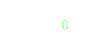

===========1================
size 16.22741127776022
energy 26.664141086833126


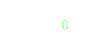

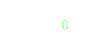

===========2================
size 18.0
energy 23.576167386173868


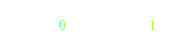

===========3================
size 18.0
energy 28.932519031558837


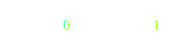

===========4================
size 22.0
energy 24.699803796949503


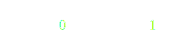

===========5================
size 22.0
energy 23.469129669007938


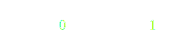

===========6================
size 22.0
energy 30.896668176157878


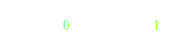

===========7================
size 22.0
energy 29.347984112024893


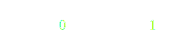

===========8================
size 22.0
energy 26.932071455079107


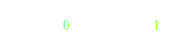

===========9================
size 22.0
energy 23.490268639193435


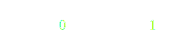

===========10================
size 22.0
energy 24.814028948421768


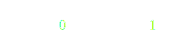

===========11================
size 22.0
energy 24.807369575322845


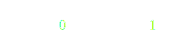

===========12================
size 22.0
energy 23.146964440644282


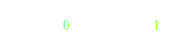

===========13================
size 22.0
energy 22.433453489831457


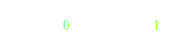

===========14================
size 22.0
energy 31.255316313797433


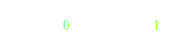

===========15================
size 22.0
energy 25.238569663140673


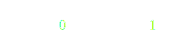

===========16================
size 22.0
energy 30.757090931984617


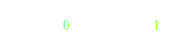

===========17================
size 22.0
energy 30.980349088003027


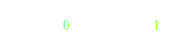

===========18================
size 22.454822555520437
energy 26.788689312388332


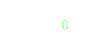

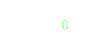

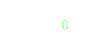

===========19================
size 24.22741127776022
energy 23.700715611729073


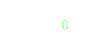

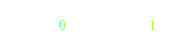

===========20================
size 24.22741127776022
energy 23.700715611729073


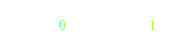

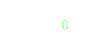

===========21================
size 24.22741127776022
energy 29.057067257114042


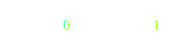

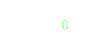

===========22================
size 24.22741127776022
energy 29.057067257114042


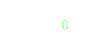

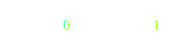

===========23================
size 26.0
energy 26.715841612805335


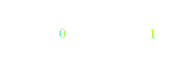

===========24================
size 26.0
energy 27.469323940167488


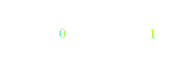

===========25================
size 26.0
energy 28.561036020916504


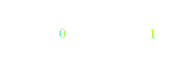

===========26================
size 28.22741127776022
energy 24.824352022504705


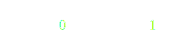

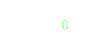

===========27================
size 28.22741127776022
energy 31.379864539352635


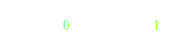

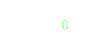

===========28================
size 28.22741127776022
energy 31.10489731355823


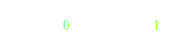

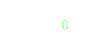

===========29================
size 28.22741127776022
energy 23.59367789456314


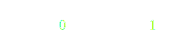

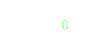

===========30================
size 28.22741127776022
energy 25.363117888695875


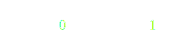

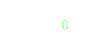

===========31================
size 28.22741127776022
energy 22.55800171538666


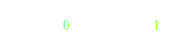

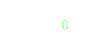

===========32================
size 28.22741127776022
energy 22.55800171538666


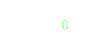

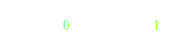

===========33================
size 28.22741127776022
energy 23.271512666199484


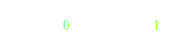

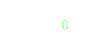

===========34================
size 28.22741127776022
energy 23.271512666199484


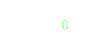

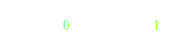

===========35================
size 28.22741127776022
energy 24.931917800878047


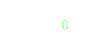

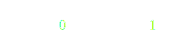

===========36================
size 28.22741127776022
energy 24.931917800878047


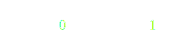

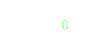

===========37================
size 28.22741127776022
energy 30.88163915753982


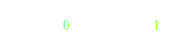

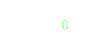

===========38================
size 28.22741127776022
energy 30.88163915753982


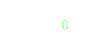

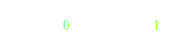

===========39================
size 28.22741127776022
energy 23.614816864748637


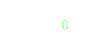

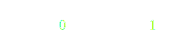

===========40================
size 28.22741127776022
energy 29.472532337580095


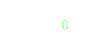

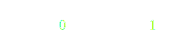

===========41================
size 30.454822555520437
energy 23.82526383728428


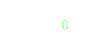

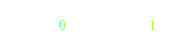

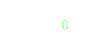

===========42================
size 30.454822555520437
energy 23.82526383728428


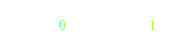

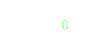

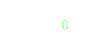

===========43================
size 30.454822555520437
energy 23.82526383728428


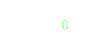

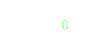

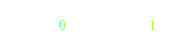

===========44================
size 30.454822555520437
energy 29.181615482669248


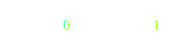

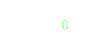

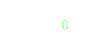

===========45================
size 30.454822555520437
energy 29.181615482669248


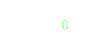

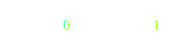

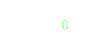

===========46================
size 30.454822555520437
energy 29.181615482669248


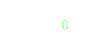

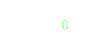

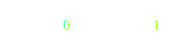

===========47================
size 30.841116916640328
energy 23.832989724506675


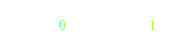

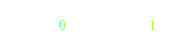

===========48================
size 30.841116916640328
energy 29.189341369891643


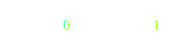

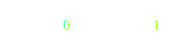

===========49================
size 30.841116916640328
energy 20.942098968083364


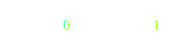

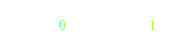

===========50================
size 34.45482255552044
energy 24.94890024805991


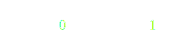

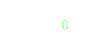

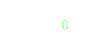

===========51================
size 34.45482255552044
energy 31.229445539113435


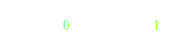

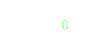

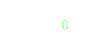

===========52================
size 34.45482255552044
energy 23.718226120118345


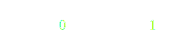

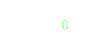

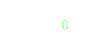

===========53================
size 34.45482255552044
energy 25.48766611425108


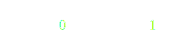

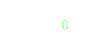

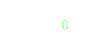

===========54================
size 34.45482255552044
energy 31.50441276490784


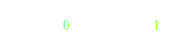

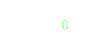

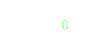

===========55================
size 34.45482255552044
energy 31.229445539113435


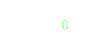

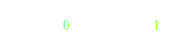

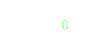

===========56================
size 34.84111691664033
energy 24.95662613528231


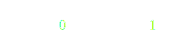

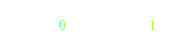

===========57================
size 34.84111691664033
energy 25.825198837639306


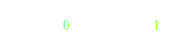

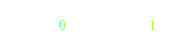

===========58================
size 34.84111691664033
energy 23.912989724506676


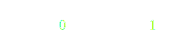

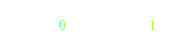

===========59================
size 34.84111691664033
energy 25.49539200147348


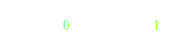

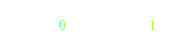

===========60================
size 34.84111691664033
energy 25.49539200147348


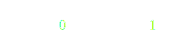

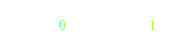

===========61================
size 34.84111691664033
energy 25.06419191365565


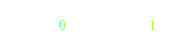

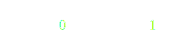

===========62================
size 34.84111691664033
energy 29.269341369891645


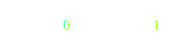

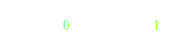

===========63================
size 38.45482255552044
energy 23.98526383728428


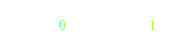

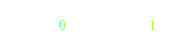

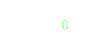

===========64================
size 38.45482255552044
energy 23.98526383728428


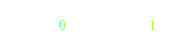

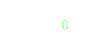

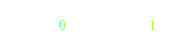

===========65================
size 38.45482255552044
energy 23.98526383728428


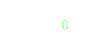

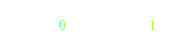

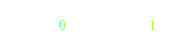

===========66================
size 38.45482255552044
energy 29.341615482669248


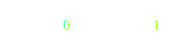

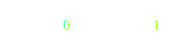

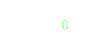

===========67================
size 38.45482255552044
energy 29.341615482669248


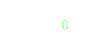

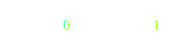

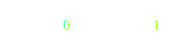

===========68================
size 38.45482255552044
energy 29.341615482669248


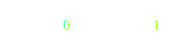

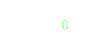

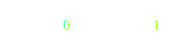

===========69================
size 38.45482255552044
energy 21.09437308086097


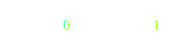

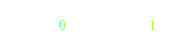

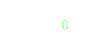

===========70================
size 38.45482255552044
energy 21.09437308086097


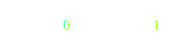

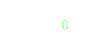

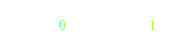

===========71================
size 38.45482255552044
energy 21.09437308086097


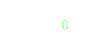

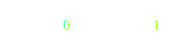

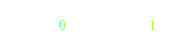

===========72================
size 38.84111691664033
energy 25.036626135282308


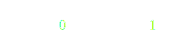

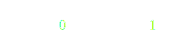

===========73================
size 38.84111691664033
energy 22.770275828164262


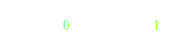

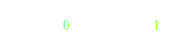

===========74================
size 38.84111691664033
energy 25.14419191365565


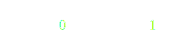

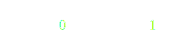

===========75================
size 38.84111691664033
energy 31.093913270317422


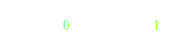

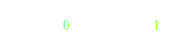

===========76================
size 38.84111691664033
energy 23.483786778977088


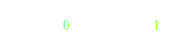

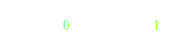

===========77================
size 42.45482255552044
energy 25.10890024805991


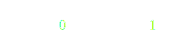

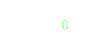

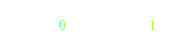

===========78================
size 42.45482255552044
energy 25.977472950416907


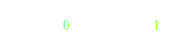

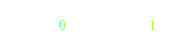

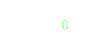

===========79================
size 42.45482255552044
energy 25.64766611425108


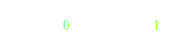

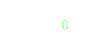

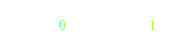

===========80================
size 42.45482255552044
energy 25.64766611425108


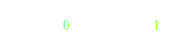

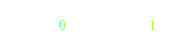

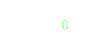

===========81================
size 42.45482255552044
energy 25.10890024805991


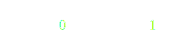

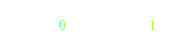

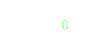

===========82================
size 42.45482255552044
energy 24.065263837284277


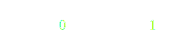

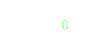

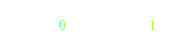

===========83================
size 42.45482255552044
energy 24.065263837284277


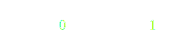

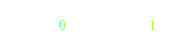

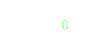

===========84================
size 42.45482255552044
energy 25.64766611425108


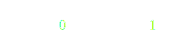

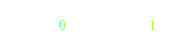

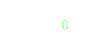

===========85================
size 42.45482255552044
energy 25.64766611425108


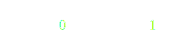

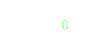

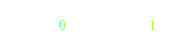

===========86================
size 42.45482255552044
energy 25.977472950416907


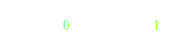

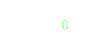

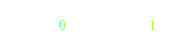

===========87================
size 42.45482255552044
energy 29.421615482669246


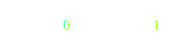

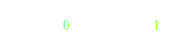

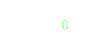

===========88================
size 42.45482255552044
energy 25.64766611425108


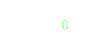

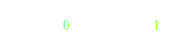

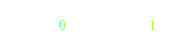

===========89================
size 43.682233833280655
energy 24.08981206283948


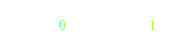

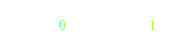

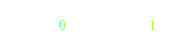

===========90================
size 43.682233833280655
energy 29.44616370822445


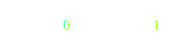

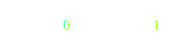

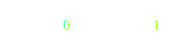

===========91================
size 43.682233833280655
energy 21.19892130641617


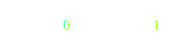

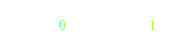

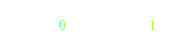

===========92================
size 43.682233833280655
energy 21.19892130641617


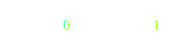

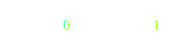

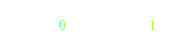

===========93================
size 47.682233833280655
energy 25.213448473615117


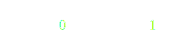

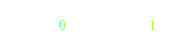

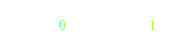

===========94================
size 47.682233833280655
energy 26.082021175972113


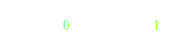

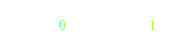

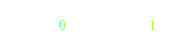

===========95================
size 47.682233833280655
energy 25.752214339806287


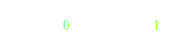

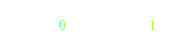

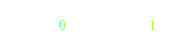

===========96================
size 47.682233833280655
energy 24.169812062839483


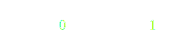

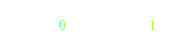

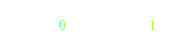

===========97================
size 47.682233833280655
energy 25.752214339806287


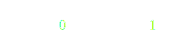

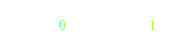

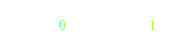

===========98================
size 47.682233833280655
energy 21.278921306416173


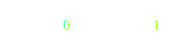

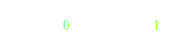

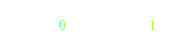

===========99================
size 51.682233833280655
energy 25.293448473615115


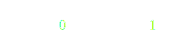

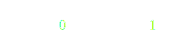

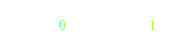

energy 20.942098968083364


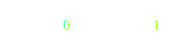

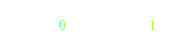

energy 21.09437308086097


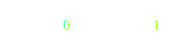

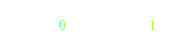

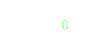

energy 21.09437308086097


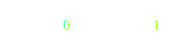

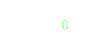

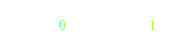

energy 21.09437308086097


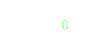

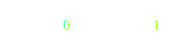

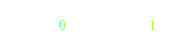

energy 21.19892130641617


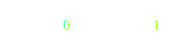

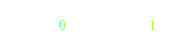

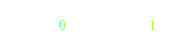

energy 21.19892130641617


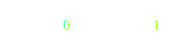

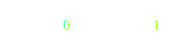

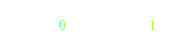

energy 21.278921306416173


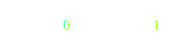

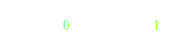

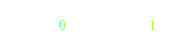

energy 22.433453489831457


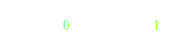

energy 22.55800171538666


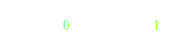

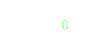

energy 22.55800171538666


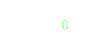

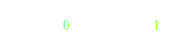

energy 22.770275828164262


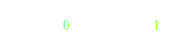

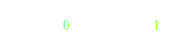

energy 23.146964440644282


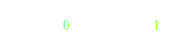

energy 23.271512666199484


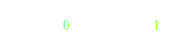

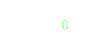

energy 23.271512666199484


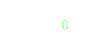

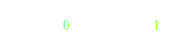

energy 23.469129669007938


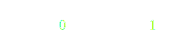

energy 23.483786778977088


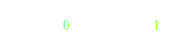

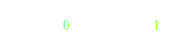

energy 23.490268639193435


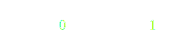

energy 23.576167386173868


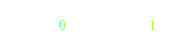

energy 23.59367789456314


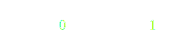

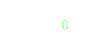

energy 23.614816864748637


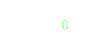

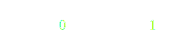

energy 23.700715611729073


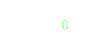

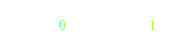

energy 23.700715611729073


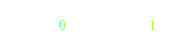

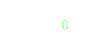

energy 23.718226120118345


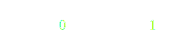

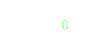

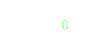

energy 23.82526383728428


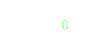

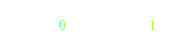

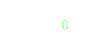

energy 23.82526383728428


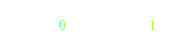

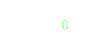

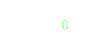

energy 23.82526383728428


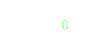

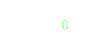

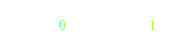

energy 23.832989724506675


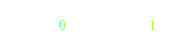

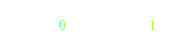

energy 23.912989724506676


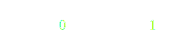

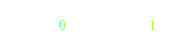

energy 23.98526383728428


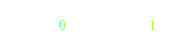

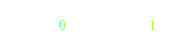

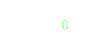

energy 23.98526383728428


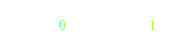

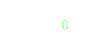

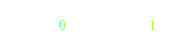

energy 23.98526383728428


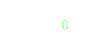

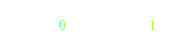

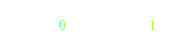

energy 24.065263837284277


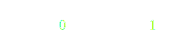

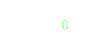

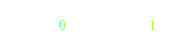

energy 24.065263837284277


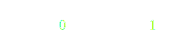

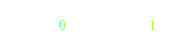

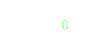

energy 24.08981206283948


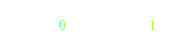

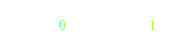

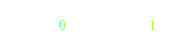

energy 24.169812062839483


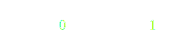

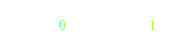

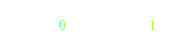

energy 24.699803796949503


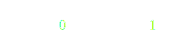

energy 24.807369575322845


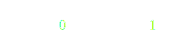

energy 24.814028948421768


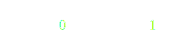

energy 24.824352022504705


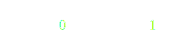

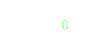

energy 24.931917800878047


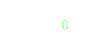

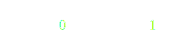

energy 24.931917800878047


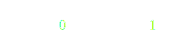

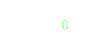

energy 24.94890024805991


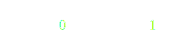

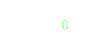

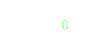

energy 24.95662613528231


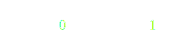

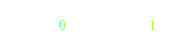

energy 25.036626135282308


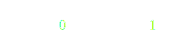

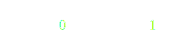

energy 25.06419191365565


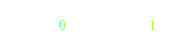

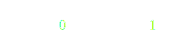

energy 25.10890024805991


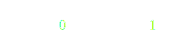

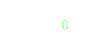

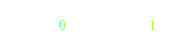

energy 25.10890024805991


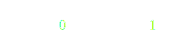

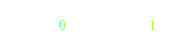

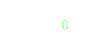

energy 25.14419191365565


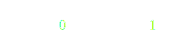

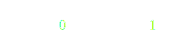

energy 25.213448473615117


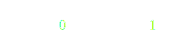

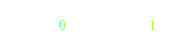

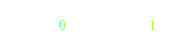

energy 25.238569663140673


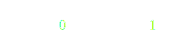

energy 25.293448473615115


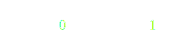

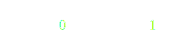

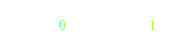

energy 25.363117888695875


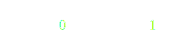

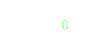

energy 25.48766611425108


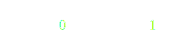

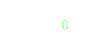

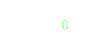

energy 25.49539200147348


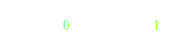

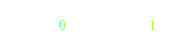

energy 25.49539200147348


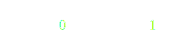

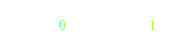

energy 25.64766611425108


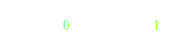

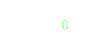

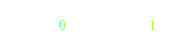

energy 25.64766611425108


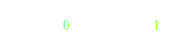

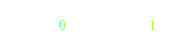

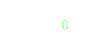

energy 25.64766611425108


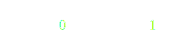

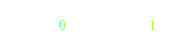

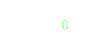

energy 25.64766611425108


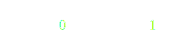

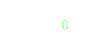

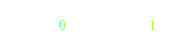

energy 25.64766611425108


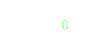

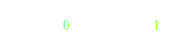

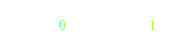

energy 25.752214339806287


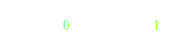

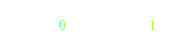

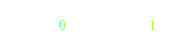

energy 25.752214339806287


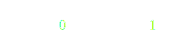

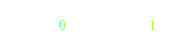

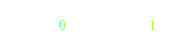

energy 25.825198837639306


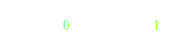

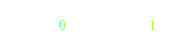

energy 25.977472950416907


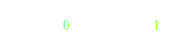

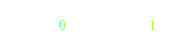

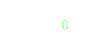

energy 25.977472950416907


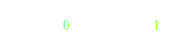

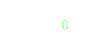

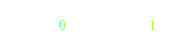

energy 26.082021175972113


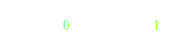

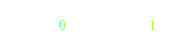

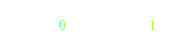

energy 26.53959286127792


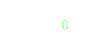

energy 26.664141086833126


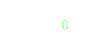

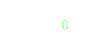

energy 26.715841612805335


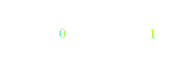

energy 26.788689312388332


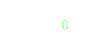

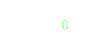

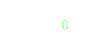

energy 26.932071455079107


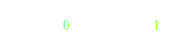

energy 27.469323940167488


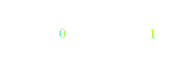

energy 28.561036020916504


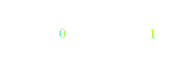

energy 28.932519031558837


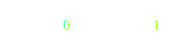

energy 29.057067257114042


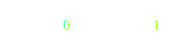

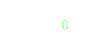

energy 29.057067257114042


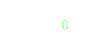

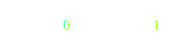

energy 29.181615482669248


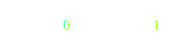

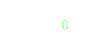

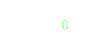

energy 29.181615482669248


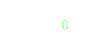

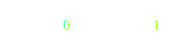

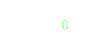

energy 29.181615482669248


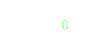

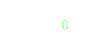

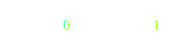

energy 29.189341369891643


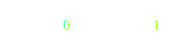

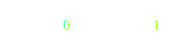

energy 29.269341369891645


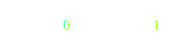

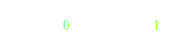

energy 29.341615482669248


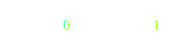

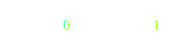

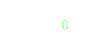

energy 29.341615482669248


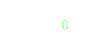

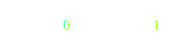

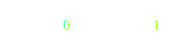

energy 29.341615482669248


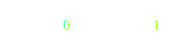

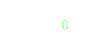

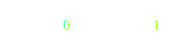

energy 29.347984112024893


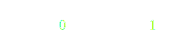

energy 29.421615482669246


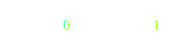

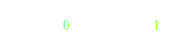

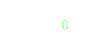

energy 29.44616370822445


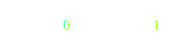

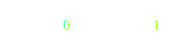

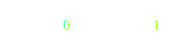

energy 29.472532337580095


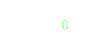

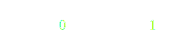

energy 30.757090931984617


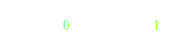

energy 30.88163915753982


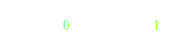

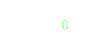

energy 30.88163915753982


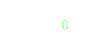

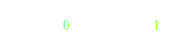

energy 30.896668176157878


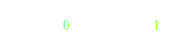

energy 30.980349088003027


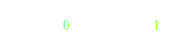

energy 31.093913270317422


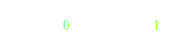

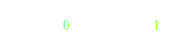

energy 31.10489731355823


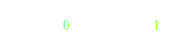

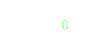

energy 31.229445539113435


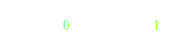

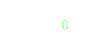

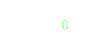

energy 31.229445539113435


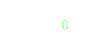

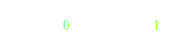

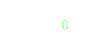

energy 31.255316313797433


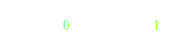

energy 31.379864539352635


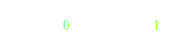

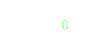

energy 31.50441276490784


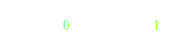

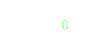

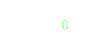

DISS:   0%|          | 0/40 [00:00<?, ?it/s]

Enumerating 40 DFAs in lexicographic order...
Sorting by size
===========0================
size 42.22741127776022
energy 15.31308121435799


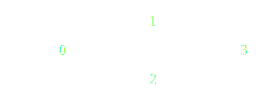

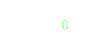

===========1================
size 48.45482255552044
energy 15.437629439913193


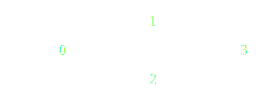

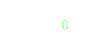

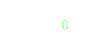

===========2================
size 48.84111691664033
energy 15.445355327135593


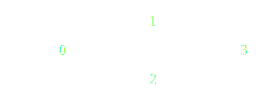

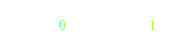

===========3================
size 48.84111691664033
energy 15.445355327135593


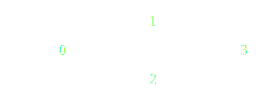

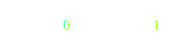

===========4================
size 52.84111691664033
energy 15.525355327135593


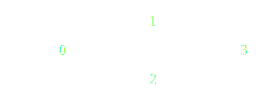

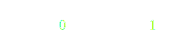

===========5================
size 52.84111691664033
energy 16.577534930238023


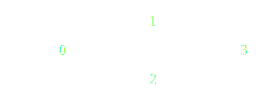

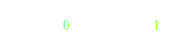

===========6================
size 52.84111691664033
energy 15.680057997279562


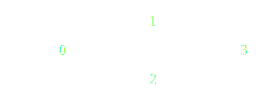

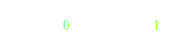

===========7================
size 52.84111691664033
energy 15.525355327135593


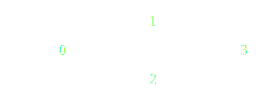

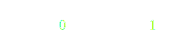

===========8================
size 52.84111691664033
energy 9.314362610092129


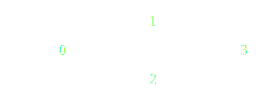

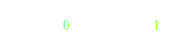

===========9================
size 54.682233833280655
energy 15.562177665468399


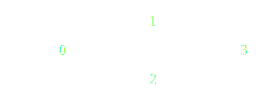

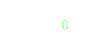

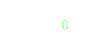

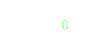

===========10================
size 56.45482255552044
energy 15.597629439913193


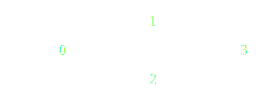

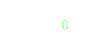

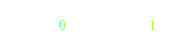

===========11================
size 56.45482255552044
energy 15.597629439913193


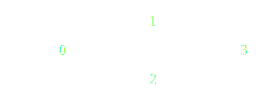

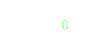

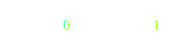

===========12================
size 56.45482255552044
energy 15.597629439913193


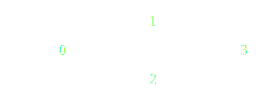

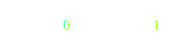

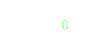

===========13================
size 56.45482255552044
energy 15.597629439913193


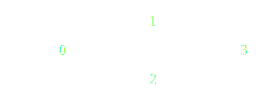

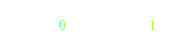

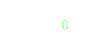

===========14================
size 60.45482255552044
energy 15.677629439913193


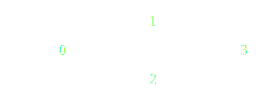

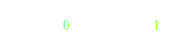

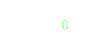

===========15================
size 60.45482255552044
energy 15.677629439913193


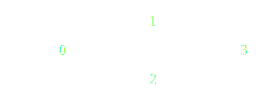

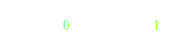

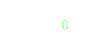

===========16================
size 60.45482255552044
energy 15.677629439913193


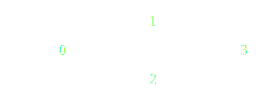

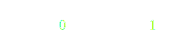

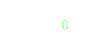

===========17================
size 60.45482255552044
energy 15.677629439913193


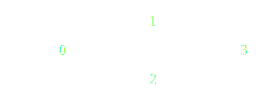

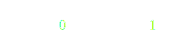

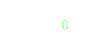

===========18================
size 61.682233833280655
energy 15.702177665468398


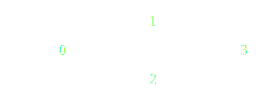

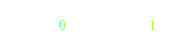

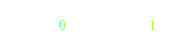

===========19================
size 61.682233833280655
energy 15.702177665468398


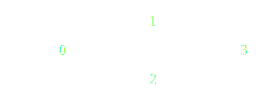

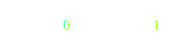

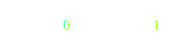

===========20================
size 61.682233833280655
energy 15.702177665468398


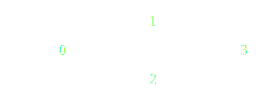

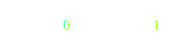

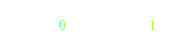

===========21================
size 62.682233833280655
energy 15.722177665468399


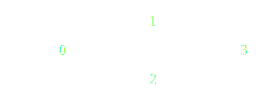

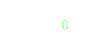

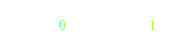

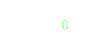

===========22================
size 62.682233833280655
energy 15.722177665468399


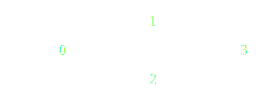

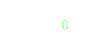

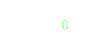

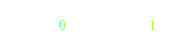

===========23================
size 62.682233833280655
energy 15.722177665468399


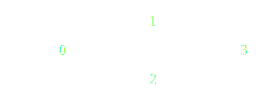

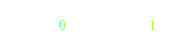

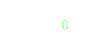

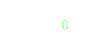

===========24================
size 62.682233833280655
energy 15.722177665468399


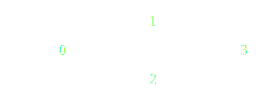

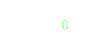

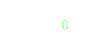

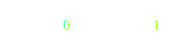

===========25================
size 62.682233833280655
energy 15.722177665468399


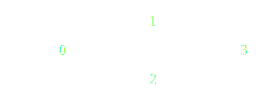

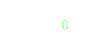

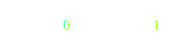

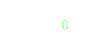

===========26================
size 62.682233833280655
energy 15.722177665468399


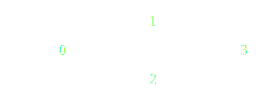

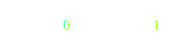

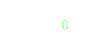

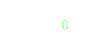

===========27================
size 65.68223383328066
energy 15.7821776654684


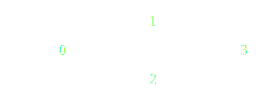

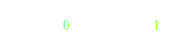

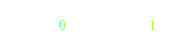

===========28================
size 65.68223383328066
energy 15.7821776654684


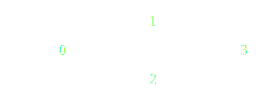

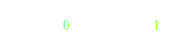

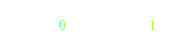

===========29================
size 70.68223383328066
energy 15.882177665468399


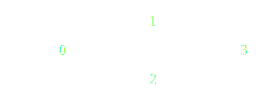

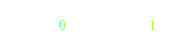

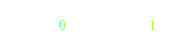

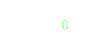

===========30================
size 70.68223383328066
energy 15.882177665468399


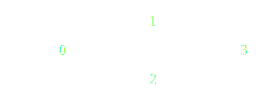

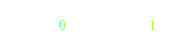

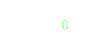

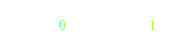

===========31================
size 70.68223383328066
energy 15.882177665468399


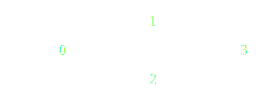

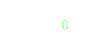

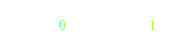

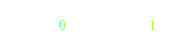

===========32================
size 70.68223383328066
energy 15.882177665468399


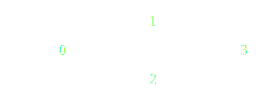

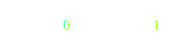

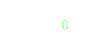

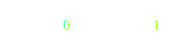

===========33================
size 70.68223383328066
energy 15.882177665468399


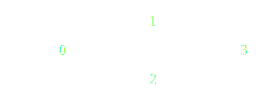

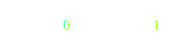

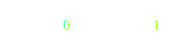

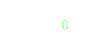

===========34================
size 70.68223383328066
energy 15.882177665468399


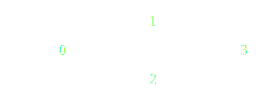

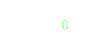

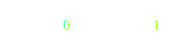

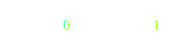

===========35================
size 70.68223383328066
energy 15.882177665468399


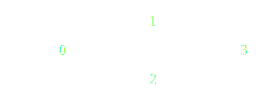

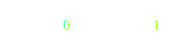

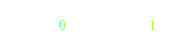

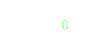

===========36================
size 74.523350749921
energy 15.959000003801204


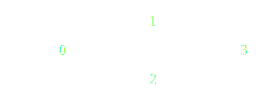

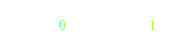

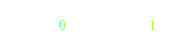

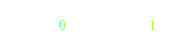

===========37================
size 74.523350749921
energy 15.959000003801204


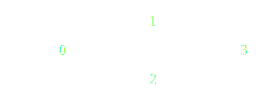

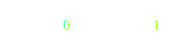

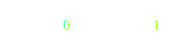

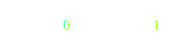

===========38================
size 74.523350749921
energy 15.959000003801204


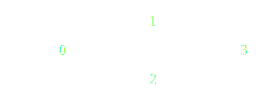

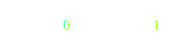

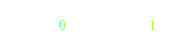

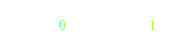

===========39================
size 78.523350749921
energy 16.039000003801206


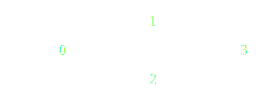

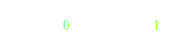

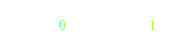

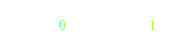

energy 9.314362610092129


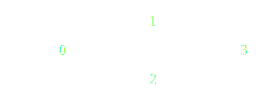

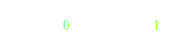

energy 15.31308121435799


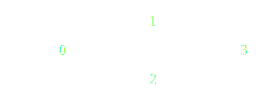

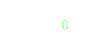

energy 15.437629439913193


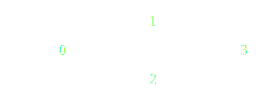

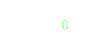

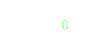

energy 15.445355327135593


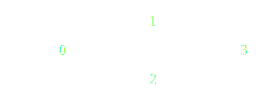

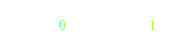

energy 15.445355327135593


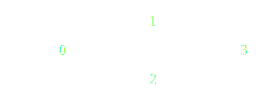

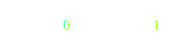

energy 15.525355327135593


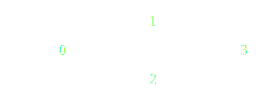

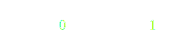

energy 15.525355327135593


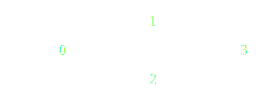

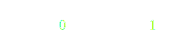

energy 15.562177665468399


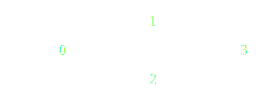

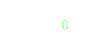

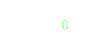

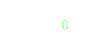

energy 15.597629439913193


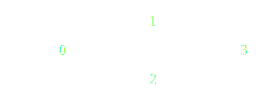

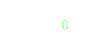

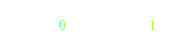

energy 15.597629439913193


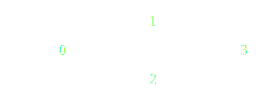

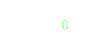

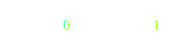

energy 15.597629439913193


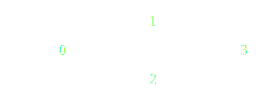

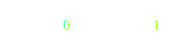

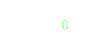

energy 15.597629439913193


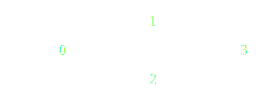

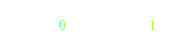

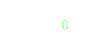

energy 15.677629439913193


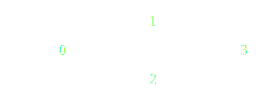

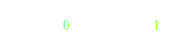

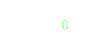

energy 15.677629439913193


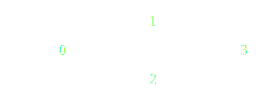

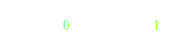

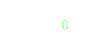

energy 15.677629439913193


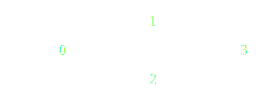

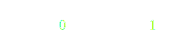

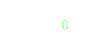

energy 15.677629439913193


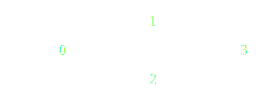

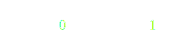

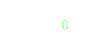

energy 15.680057997279562


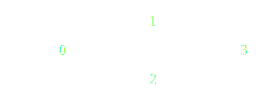

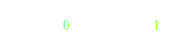

energy 15.702177665468398


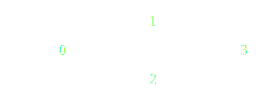

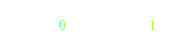

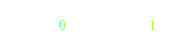

energy 15.702177665468398


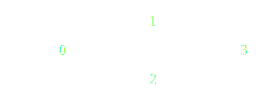

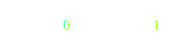

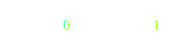

energy 15.702177665468398


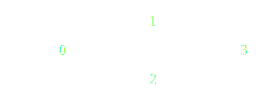

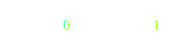

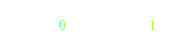

energy 15.722177665468399


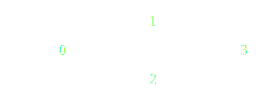

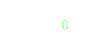

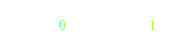

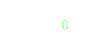

energy 15.722177665468399


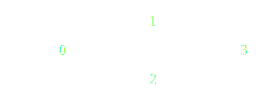

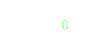

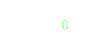

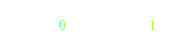

energy 15.722177665468399


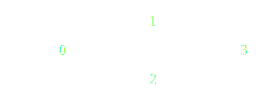

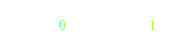

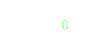

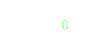

energy 15.722177665468399


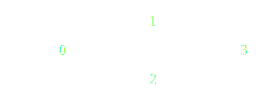

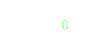

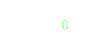

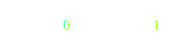

energy 15.722177665468399


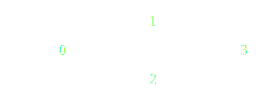

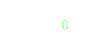

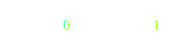

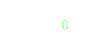

energy 15.722177665468399


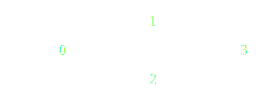

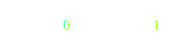

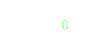

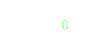

energy 15.7821776654684


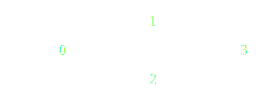

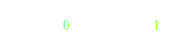

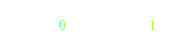

energy 15.7821776654684


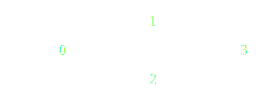

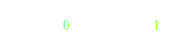

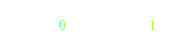

energy 15.882177665468399


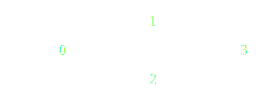

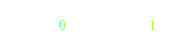

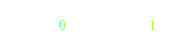

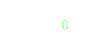

energy 15.882177665468399


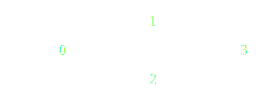

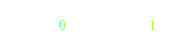

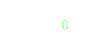

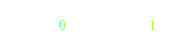

energy 15.882177665468399


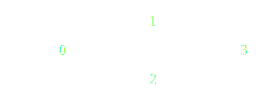

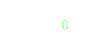

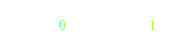

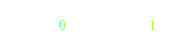

energy 15.882177665468399


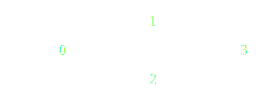

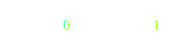

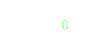

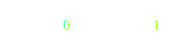

energy 15.882177665468399


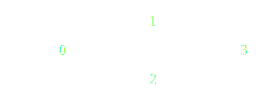

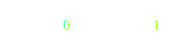

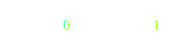

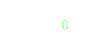

energy 15.882177665468399


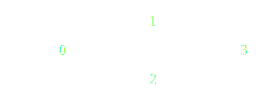

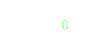

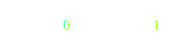

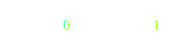

energy 15.882177665468399


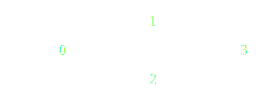

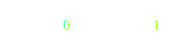

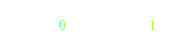

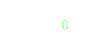

energy 15.959000003801204


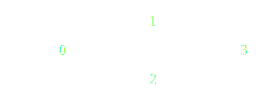

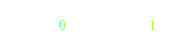

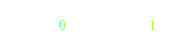

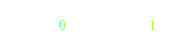

energy 15.959000003801204


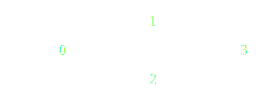

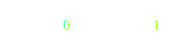

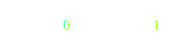

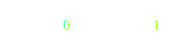

energy 15.959000003801204


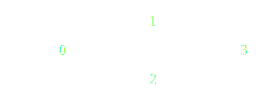

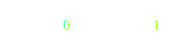

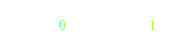

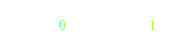

energy 16.039000003801206


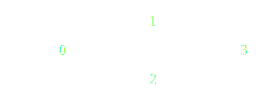

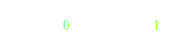

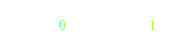

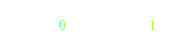

energy 16.577534930238023


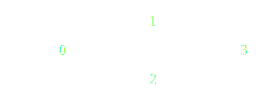

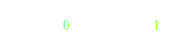

In [17]:
enumeration_dfs = []
for n_iters, monolithic in [(100, True), (40, False)]:
    def to_chain(product_c, t, psat):
        dfas = [dfa_concept.dfa for dfa_concept in product_c.dfa_concepts]
        monolithic_dfa = dfa.utils.minimize(reduce(lambda x, y: x & y, dfas))
        c = DFAConcept.from_dfa(monolithic_dfa)
        return planner.plan(c, t, psat, monolithic=monolithic, use_rationality=True)

    pos_examples_mono = LabeledExamples(negative=[], positive=[('blue', 'green', 'yellow'), ('yellow',)])
    pos_examples_inc = BASE_EXAMPLES @ LabeledExamples(negative=[], positive=[('blue', 'green', 'yellow'), ('yellow',), ('yellow', 'yellow')])

    identifer = PartialProductDFAIdentifier(
        partials = None if monolithic else [PARTIAL_DFA],
        base_examples = pos_examples_mono if monolithic else pos_examples_inc,
        alphabet=universal.inputs)

    dfa_search = concept_class.decomposition_enumerative_search(
        demos=[to_demo(TRC4), to_demo(TRC5)] if monolithic else [to_demo(TRC4[:-1])],
        identifer=identifer,
        to_chain=to_chain,
        competency=lambda *_: 0.8,
        n_iters=n_iters,
        surprise_weight=1,  # Rescale surprise to make comparable to size.
        size_weight=1/50,
    )

    df3, _ = analyze(dfa_search, n_iters)
    df3['experiment'] = 'Monolithic' if monolithic else 'Incremental'
    df3['treatment'] = 'enumeration'
    df3['iteration'] = df3.index
    enumeration_dfs.append(df3)
df = pd.concat(enumeration_dfs, ignore_index=True)
df['experiment'] = 'Enumeration'
df.to_json( f'experiment_enumeration_beta.json')

# Analysis

In [23]:
df_mono = pd.read_json( f'experiment_mono_beta.json')
df_inc = pd.read_json( f'experiment_inc_beta.json')
# enumeration_dfs = pd.read_json( f'experiment_enumeration_beta.json')

In [24]:
# Normalize all energies between 0 and 1.
for tmp1, tmp2 in zip([df_mono, df_inc], enumeration_dfs):
    U1, U2 = tmp1['min energies'], tmp2['min energies']
    U_min = min(U1.min(), U2.min())
    U_max = max(U1.max(), U2.max())
    
    for tmp in [tmp1, tmp2]:
        U = tmp['min energies']
        tmp['U'] = (U - U_min) / (U_max- U_min)

In [25]:
# Normalize all energies between 0 and 1 without enumerative approach
for tmp1, tmp2 in zip([df_mono, df_inc], enumeration_dfs):
    U1, U2 = tmp1['min energies'], tmp2['min energies']
    U_min = min(U1.min(), U2.min())
    U_max = max(U1.max(), U2.max())
    
    for tmp in [tmp1, tmp2]:
        U = tmp['min energies']
        tmp['U'] = (U - U_min) / (U_max- U_min)

In [26]:
df_mono['experiment'] = 'Monolithic'
df_inc['experiment'] = 'Incremental'
diss_dfs = [df_mono, df_inc]

In [27]:
enumeration_dfs[0]['experiment'] = 'Monolithic'
enumeration_dfs[1]['experiment'] = 'Incremental'
#df_enum = pd.concat(enumeration_dfs)

In [18]:
sns.set(rc={"figure.figsize":(10, 6)})

mapcolor = 'rocket'

for df_diss, df_enum, iters, experiment, title in zip(diss_dfs, enumeration_dfs, [80, 40], ['Monolithic', 'Incremental'], ['No partial knowledge', 'Partial knowledge']):
    if experiment == 'Incremental' or True:
        plot = plt.scatter(list(range(21)), list(range(-10, 11)), c=list(range(-10, 11)), cmap=mapcolor, zorder=1)
        plt.clf()
        cbar = plt.colorbar(plot, extend='max')
        cbar.ax.set_ylabel(r'$\ln \beta$', rotation=270, fontsize=16)
    hdl = plt.plot(df_enum['iteration'], df_enum['U'], '--', c='black', label='enumerate', zorder=2)
    grid = sns.lineplot(
        data=df_diss, x='iteration', y='U',
        palette=mapcolor, hue='treatment', legend=False, 
        estimator=np.median, ci=None,
        zorder=1,
    )
    plt.title(f'{title}', fontsize=20)
    plt.xlim(0, iters)
    plt.xlabel('Iteration', fontsize=20)
    plt.ylabel('(normalized) minumum energy decomposition', fontsize=20)
    plt.legend(fontsize=16)

    plt.savefig(f'mass_{experiment}.pgf', bbox_inches='tight', pad_inches=0)
    plt.savefig(f'mass_{experiment}.png', bbox_inches='tight')
    plt.show()

    
#
#plt.savefig('mass_mono2.pgf')

NameError: name 'diss_dfs' is not defined